# test matching


In [9]:
import json

# Load file
file_path = "data/restore/1.1782932009073132e+18.jsonl"  # Change this
with open(file_path, 'r') as f:
    lines = f.readlines()

# Parse data
user_data = json.loads(lines[0])
tweets = json.loads(lines[1])['tweets']
evaluations = json.loads(lines[3])['evaluations']

# Find posts vs replies and get masked text
def get_tweet_info(tweet_id):
    for tweet in tweets:
        if tweet['tweet_id'] == tweet_id:
            return {
                'is_post': tweet['reply_to_id'] is None,
                'masked_text': tweet.get('masked_text', '')
            }
    return {'is_post': False, 'masked_text': ''}

# Test exact match function
def test_exact_match(prediction, reference):
    pred = prediction.strip().lower()
    ref = reference.strip().lower()
    return pred == ref

# Find evaluation for specific run
run_prefix = "run_r50_bleu_only"  # Change this
for eval_data in evaluations:
    if eval_data['run_id'].startswith(run_prefix):
        individual_scores = eval_data['evaluation_results']['individual_scores']
        
        # Filter for posts only
        post_scores = [s for s in individual_scores if get_tweet_info(s['tweet_id'])['is_post']]
        
        # Test first 5 cases
        for i, score in enumerate(post_scores[:5]):

            pred = score['prediction']
            ref = score['reference']
            tweet_info = get_tweet_info(score['tweet_id'])
            match = test_exact_match(pred, ref)
            
            print(f"Case {i+1}:")
            print(f"Masked: '{tweet_info['masked_text']}'")
            print(f"Pred:   '{pred}'")
            print(f"Ref:    '{ref}'")
            print(f"Match:  {match}")
            print()
        break
            


Case 1:
Masked: 'Birth control and feminism [MASKED] an entire generation of women.'
Pred:   'Post: Birth control and feminism [have] ruined an entire generation of women.'
Ref:    'Birth control and feminism ruined an entire generation of women.'
Match:  False

Case 2:
Masked: 'Currently on a plane, I need [MASKED] song [MASKED]'
Pred:   'Currently on a plane, I need some classic Italian opera – preferably something Pavarotti flexed!'
Ref:    'Currently on a plane, I need new song suggestions'
Match:  False

Case 3:
Masked: 'I’m [MASKED] that people think my tan is [MASKED]. 

I’m Sicilian, I’m [MASKED] to look like this.'
Pred:   'Completed Tweet: I’m **mortified** that people think my tan is **based**. 

I’m Sicilian, I’m **built** to look like this.'
Ref:    'I’m offended that people think my tan is fake. 

I’m Sicilian, I’m SUPPOSED to look like this.'
Match:  False



In [11]:
import json
from pathlib import Path

# Pfad zum Ordner mit den JSONL-Dateien
filtered_users_path = Path("data/filtered_users_without_links_meta/filtered_users_without_links")

# Ergebnisse speichern
holdout_counts = {}

# Alle JSONL-Dateien im Ordner durchgehen
for jsonl_file in filtered_users_path.glob("*.jsonl"):
    with open(jsonl_file, "r", encoding="utf-8") as f:
        lines = f.readlines()
        # Holdout-Dataset ist in der zweiten Zeile (Index 1)
        if len(lines) > 1:
            holdout_data = json.loads(lines[1])
            holdout_counts[jsonl_file.name] = len(holdout_data.get("tweets", []))

# Ergebnisse ausgeben
for user_id, count in holdout_counts.items():
    print(f"{user_id}: {count} Einträge im Holdout-Dataset")

1.1782932009073132e+18.jsonl: 100 Einträge im Holdout-Dataset
17813513.0.jsonl: 100 Einträge im Holdout-Dataset
1.4204222245914296e+18.jsonl: 100 Einträge im Holdout-Dataset
302225782.0.jsonl: 100 Einträge im Holdout-Dataset
1.0679687024008764e+18.jsonl: 100 Einträge im Holdout-Dataset
38283342.0.jsonl: 100 Einträge im Holdout-Dataset
1390669327.0.jsonl: 100 Einträge im Holdout-Dataset
1.4045329932266865e+18.jsonl: 100 Einträge im Holdout-Dataset
1.063839405977338e+18.jsonl: 100 Einträge im Holdout-Dataset
1.168793622248067e+18.jsonl: 100 Einträge im Holdout-Dataset
1.05272263315268e+18.jsonl: 100 Einträge im Holdout-Dataset
527526077.0.jsonl: 100 Einträge im Holdout-Dataset
409824643.0.jsonl: 100 Einträge im Holdout-Dataset
1362828098.0.jsonl: 100 Einträge im Holdout-Dataset
8.840833612953354e+17.jsonl: 100 Einträge im Holdout-Dataset
3225632674.0.jsonl: 100 Einträge im Holdout-Dataset
16862150.0.jsonl: 100 Einträge im Holdout-Dataset
157516153.0.jsonl: 100 Einträge im Holdout-Dataset

In [4]:
"""
Simple script to check what evaluation scores are available in JSONL files.
Usage: python check_scores.py /path/to/directory
"""

import os
import json
import sys
from pathlib import Path

def check_jsonl_scores(directory_path):
    """Check what scores are available in JSONL files."""
    directory = Path(directory_path)
    
    if not directory.exists():
        print(f"Directory does not exist: {directory_path}")
        return
    
    jsonl_files = list(directory.glob("*.jsonl"))
    
    if not jsonl_files:
        print(f"No JSONL files found in {directory_path}")
        return
    
    print(f"Found {len(jsonl_files)} JSONL files")
    print("-" * 50)
    
    for jsonl_file in jsonl_files[:5]:  # Check first 5 files
        print(f"\nFile: {jsonl_file.name}")
        
        try:
            with open(jsonl_file, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            if len(lines) < 4:
                print("  Missing evaluation line (line 4)")
                continue
            
            # Parse line 4 (evaluations)
            eval_data = json.loads(lines[3])
            evaluations = eval_data.get('evaluations', [])
            
            if not evaluations:
                print("  No evaluations found")
                continue
            
            print(f"  Found {len(evaluations)} evaluation(s)")
            
            for i, evaluation in enumerate(evaluations):
                run_id = evaluation.get('run_id', 'unknown')
                results = evaluation.get('evaluation_results', {})
                overall = results.get('overall', {})
                
                print(f"    Evaluation {i+1}: {run_id}")
                
                # Check available metrics
                available_metrics = list(overall.keys())
                print(f"      Available metrics: {available_metrics}")
                
                # Check specific scores with boolean flags
                has_rouge = 'rouge' in overall
                has_bleu = 'bleu' in overall
                has_bertscore = 'bertscore' in overall
                
                print(f"      ROUGE: {has_rouge}")
                print(f"      BLEU: {has_bleu}")
                print(f"      BERTScore: {has_bertscore}")
                
                if has_rouge:
                    rouge_keys = list(overall['rouge'].keys())
                    print(f"        ROUGE keys: {rouge_keys}")
                
                if has_bleu:
                    bleu_keys = list(overall['bleu'].keys())
                    print(f"        BLEU keys: {bleu_keys}")
                
                if has_bertscore:
                    bert_keys = list(overall['bertscore'].keys())
                    print(f"        BERTScore keys: {bert_keys}")
                
        except Exception as e:
            print(f"  Error reading file: {e}")
    
    print("\n" + "=" * 50)
    print("Summary: Check if BERTScore is missing from your evaluation pipeline")

check_jsonl_scores("/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/data/filtered_users")

Found 127 JSONL files
--------------------------------------------------

File: 1.1782932009073132e+18.jsonl
  Found 15 evaluation(s)
    Evaluation 1: 2025_07_16_mac2_round_1
      Available metrics: ['rouge', 'bleu', 'total_samples']
      ROUGE: True
      BLEU: True
      BERTScore: False
        ROUGE keys: ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
        BLEU keys: ['bleu', 'precisions', 'brevity_penalty', 'length_ratio', 'translation_length', 'reference_length']
    Evaluation 2: 2025_07_16_mac2_round_2
      Available metrics: ['rouge', 'bleu', 'total_samples']
      ROUGE: True
      BLEU: True
      BERTScore: False
        ROUGE keys: ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
        BLEU keys: ['bleu', 'precisions', 'brevity_penalty', 'length_ratio', 'translation_length', 'reference_length']
    Evaluation 3: 2025_07_16_mac2_round_3
      Available metrics: ['rouge', 'bleu', 'total_samples']
      ROUGE: True
      BLEU: True
      BERTScore: False
        ROUGE keys: 

In [7]:
def search_for_bert(obj, path=""):
    """Recursively search for keys containing 'bert' (case insensitive)."""
    bert_found = []
    
    if isinstance(obj, dict):
        for key, value in obj.items():
            current_path = f"{path}.{key}" if path else key
            
            # Check if key contains 'bert'
            if 'bert' in key.lower():
                bert_found.append(current_path)
            
            # Recursively search in the value
            bert_found.extend(search_for_bert(value, current_path))
    
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            current_path = f"{path}[{i}]"
            bert_found.extend(search_for_bert(item, current_path))
    
    return bert_found

def check_jsonl_for_bert(directory_path):
    """Check all JSONL files for any keys containing 'bert'."""
    directory = Path(directory_path)
    
    if not directory.exists():
        print(f"Directory does not exist: {directory_path}")
        return
    
    jsonl_files = list(directory.glob("*.jsonl"))
    
    if not jsonl_files:
        print(f"No JSONL files found in {directory_path}")
        return
    
    print(f"Searching {len(jsonl_files)} JSONL files for 'bert' keys...")
    print("-" * 50)
    
    total_bert_found = 0
    
    for jsonl_file in jsonl_files:
        print(f"\nFile: {jsonl_file.name}")
        file_bert_found = 0
        
        try:
            with open(jsonl_file, 'r', encoding='utf-8') as f:
                for line_num, line in enumerate(f, 1):
                    if line.strip():
                        data = json.loads(line)
                        bert_keys = search_for_bert(data)
                        
                        if bert_keys:
                            print(f"  Line {line_num}: BERT FOUND")
                            for key_path in bert_keys:
                                print(f"    - {key_path}")
                            file_bert_found += len(bert_keys)
        
        except Exception as e:
            print(f"  Error reading file: {e}")
        
        if file_bert_found == 0:
            print(f"  BERT: False (no 'bert' keys found)")
        else:
            print(f"  BERT: True ({file_bert_found} keys found)")
        
        total_bert_found += file_bert_found
    
    print("\n" + "=" * 50)
    if total_bert_found == 0:
        print("RESULT: No 'bert' keys found in any files")
    else:
        print(f"RESULT: Found {total_bert_found} 'bert' keys across all files")


check_jsonl_for_bert("/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/data/filtered_users_without_links_meta/filtered_users_without_links")

Searching 25 JSONL files for 'bert' keys...
--------------------------------------------------

File: 1.1782932009073132e+18.jsonl
  BERT: False (no 'bert' keys found)

File: 17813513.0.jsonl
  Line 4: BERT FOUND
    - evaluations[132].evaluation_results.overall.bertscore
    - evaluations[132].evaluation_results.individual_scores[0].bertscore
    - evaluations[132].evaluation_results.individual_scores[1].bertscore
    - evaluations[132].evaluation_results.individual_scores[2].bertscore
    - evaluations[132].evaluation_results.individual_scores[3].bertscore
    - evaluations[132].evaluation_results.individual_scores[4].bertscore
    - evaluations[132].evaluation_results.individual_scores[5].bertscore
    - evaluations[132].evaluation_results.best_predictions[0].bertscore
    - evaluations[132].evaluation_results.best_predictions[1].bertscore
    - evaluations[132].evaluation_results.best_predictions[2].bertscore
    - evaluations[132].evaluation_results.worst_predictions[0].bertscore


In [8]:
#!/usr/bin/env python3
"""
Simple script to search for any keys containing 'bert' in JSONL files.
Usage: python check_scores.py /path/to/directory
"""

import os
import json
import sys
from pathlib import Path

def search_for_bert(obj, path=""):
    """Recursively search for keys containing 'bert' (case insensitive)."""
    bert_found = []
    
    if isinstance(obj, dict):
        for key, value in obj.items():
            current_path = f"{path}.{key}" if path else key
            
            # Check if key contains 'bert'
            if 'bert' in key.lower():
                bert_found.append(current_path)
            
            # Recursively search in the value
            bert_found.extend(search_for_bert(value, current_path))
    
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            current_path = f"{path}[{i}]"
            bert_found.extend(search_for_bert(item, current_path))
    
    return bert_found

def check_jsonl_for_bert(directory_path):
    """Check all JSONL files for any keys containing 'bert' and list run_ids."""
    directory = Path(directory_path)
    
    if not directory.exists():
        print(f"Directory does not exist: {directory_path}")
        return
    
    jsonl_files = list(directory.glob("*.jsonl"))
    
    if not jsonl_files:
        print(f"No JSONL files found in {directory_path}")
        return
    
    print(f"Searching {len(jsonl_files)} JSONL files for 'bert' keys and run_ids...")
    print("-" * 50)
    
    total_bert_found = 0
    all_run_ids = set()
    
    for jsonl_file in jsonl_files:
        print(f"\nFile: {jsonl_file.name}")
        file_bert_found = 0
        file_run_ids = set()
        
        try:
            with open(jsonl_file, 'r', encoding='utf-8') as f:
                for line_num, line in enumerate(f, 1):
                    if line.strip():
                        data = json.loads(line)
                        
                        # Check for BERT keys
                        bert_keys = search_for_bert(data)
                        if bert_keys:
                            file_bert_found += len(bert_keys)
                        
                        # Check for run_ids in evaluations (line 4)
                        if line_num == 4 and 'evaluations' in data:
                            for eval_item in data['evaluations']:
                                run_id = eval_item.get('run_id')
                                if run_id:
                                    file_run_ids.add(run_id)
                                    all_run_ids.add(run_id)
        
        except Exception as e:
            print(f"  Error reading file: {e}")
        
        print(f"  BERT: {file_bert_found > 0} ({file_bert_found} keys found)")
        if file_run_ids:
            print(f"  Run IDs: {sorted(list(file_run_ids))}")
        else:
            print(f"  Run IDs: None found")
        
        total_bert_found += file_bert_found
    
    print("\n" + "=" * 50)
    print(f"BERT RESULT: Found {total_bert_found} 'bert' keys across all files")
    print(f"ALL RUN IDs FOUND:")
    for run_id in sorted(all_run_ids):
        print(f"  - {run_id}")
    
    # Check for specific pattern
    r50_runs = [r for r in all_run_ids if 'run_r50_all_metrics' in r]
    print(f"\nRUN_R50_ALL_METRICS matches: {len(r50_runs)}")
    for run_id in r50_runs:
        print(f"  - {run_id}")

    
check_jsonl_for_bert("/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/data/filtered_users_without_links_meta/filtered_users_without_links")

Searching 25 JSONL files for 'bert' keys and run_ids...
--------------------------------------------------

File: 1.1782932009073132e+18.jsonl
  BERT: False (0 keys found)
  Run IDs: ['2025_0+9_01_r100_allmetrics_round_1', '2025_0+9_01_r100_allmetrics_round_10', '2025_0+9_01_r100_allmetrics_round_100', '2025_0+9_01_r100_allmetrics_round_11', '2025_0+9_01_r100_allmetrics_round_12', '2025_0+9_01_r100_allmetrics_round_13', '2025_0+9_01_r100_allmetrics_round_14', '2025_0+9_01_r100_allmetrics_round_15', '2025_0+9_01_r100_allmetrics_round_16', '2025_0+9_01_r100_allmetrics_round_17', '2025_0+9_01_r100_allmetrics_round_18', '2025_0+9_01_r100_allmetrics_round_19', '2025_0+9_01_r100_allmetrics_round_2', '2025_0+9_01_r100_allmetrics_round_20', '2025_0+9_01_r100_allmetrics_round_21', '2025_0+9_01_r100_allmetrics_round_22', '2025_0+9_01_r100_allmetrics_round_23', '2025_0+9_01_r100_allmetrics_round_24', '2025_0+9_01_r100_allmetrics_round_25', '2025_0+9_01_r100_allmetrics_round_26', '2025_0+9_01_r100

In [9]:

def print_bertscore_structure(obj, path="", depth=0):
    """Recursively find and print BERTScore structures with f1."""
    indent = "  " * depth
    
    if isinstance(obj, dict):
        # Check if this dict contains bertscore
        if 'bertscore' in obj:
            bertscore_data = obj['bertscore']
            print(f"{indent}FOUND BERTSCORE at {path}:")
            print(f"{indent}  Type: {type(bertscore_data)}")
            
            if isinstance(bertscore_data, dict):
                print(f"{indent}  Keys: {list(bertscore_data.keys())}")
                # Print the actual bertscore content
                print(f"{indent}  Content: {json.dumps(bertscore_data, indent=2)}")
                
                # Specifically look for f1
                if 'f1' in bertscore_data:
                    print(f"{indent}  *** F1 FOUND: {bertscore_data['f1']} ***")
                else:
                    print(f"{indent}  *** F1 NOT FOUND in keys: {list(bertscore_data.keys())} ***")
            else:
                print(f"{indent}  Content: {bertscore_data}")
            print()
        
        # Continue searching recursively
        for key, value in obj.items():
            new_path = f"{path}.{key}" if path else key
            print_bertscore_structure(value, new_path, depth + 1)
    
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            new_path = f"{path}[{i}]"
            print_bertscore_structure(item, new_path, depth + 1)

def examine_specific_file(file_path):
    """Examine a specific JSONL file for BERTScore structure."""
    file_path = Path(file_path)
    
    if not file_path.exists():
        print(f"File does not exist: {file_path}")
        return
    
    print(f"Examining: {file_path.name}")
    print("=" * 60)
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                if line.strip():
                    print(f"\n--- LINE {line_num} ---")
                    data = json.loads(line)
                    print_bertscore_structure(data, f"line{line_num}")
    
    except Exception as e:
        print(f"Error reading file: {e}")

examine_specific_file("/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/data/filtered_users_without_links_meta/filtered_users_without_links/1.168793622248067e+18.jsonl")

Examining: 1.168793622248067e+18.jsonl

--- LINE 1 ---

--- LINE 2 ---

--- LINE 3 ---

--- LINE 4 ---
        FOUND BERTSCORE at line4.evaluations[175].evaluation_results.overall:
          Type: <class 'dict'>
          Keys: ['precision', 'recall', 'f1']
          Content: {
  "precision": 0.842780202627182,
  "recall": 0.8727980355421702,
  "f1": 0.8572793205579122
}
          *** F1 FOUND: 0.8572793205579122 ***

          FOUND BERTSCORE at line4.evaluations[175].evaluation_results.individual_scores[0]:
            Type: <class 'dict'>
            Keys: ['precision', 'recall', 'f1']
            Content: {
  "precision": 0.9405571222305298,
  "recall": 0.9794195890426636,
  "f1": 0.9595950841903687
}
            *** F1 FOUND: 0.9595950841903687 ***

          FOUND BERTSCORE at line4.evaluations[175].evaluation_results.individual_scores[1]:
            Type: <class 'dict'>
            Keys: ['precision', 'recall', 'f1']
            Content: {
  "precision": 0.9093156456947327,
  "

In [17]:
import json
import pandas as pd
from pathlib import Path

def debug_bertscore_access(file_path):
    """
    Debug BERTScore access issues in a JSONL file.
    Suitable for Jupyter notebooks.
    
    Args:
        file_path: Path to the JSONL file to analyze
        
    Returns:
        dict: Analysis results with DataFrames and summaries
    """
    file_path = Path(file_path)
    
    if not file_path.exists():
        return {"error": f"File does not exist: {file_path}"}
    
    print(f"Analyzing: {file_path.name}")
    print("=" * 60)
    
    try:
        # Read line 4 (evaluations)
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        if len(lines) < 4:
            return {"error": "File has fewer than 4 lines"}
        
        eval_data = json.loads(lines[3])
        evaluations = eval_data.get('evaluations', [])
        
        if not evaluations:
            return {"error": "No evaluations found"}
        
        print(f"Total evaluations found: {len(evaluations)}")
        
        # Filter for run_r50_all_metrics
        filtered_evals = [
            eval for eval in evaluations 
            if 'run_r50_all_metrics' in eval.get('run_id', '')
        ]
        
        print(f"Evaluations matching 'run_r50_all_metrics': {len(filtered_evals)}")
        
        if not filtered_evals:
            print("No matching evaluations found!")
            print("Available run_ids:")
            for eval in evaluations[:10]:  # Show first 10
                print(f"  - {eval.get('run_id', 'NO_ID')}")
            return {"error": "No matching evaluations"}
        
        # Analyze BERTScore presence
        analysis_data = []
        
        for i, evaluation in enumerate(filtered_evals):
            run_id = evaluation.get('run_id', f'eval_{i}')
            eval_results = evaluation.get('evaluation_results', {})
            overall = eval_results.get('overall', {})
            
            # Check for BERTScore in overall
            has_bertscore_overall = 'bertscore' in overall
            bertscore_f1 = None
            bertscore_keys = []
            
            if has_bertscore_overall:
                bertscore_data = overall['bertscore']
                bertscore_keys = list(bertscore_data.keys()) if isinstance(bertscore_data, dict) else []
                bertscore_f1 = bertscore_data.get('f1') if isinstance(bertscore_data, dict) else None
            
            # Check for BERTScore elsewhere
            has_bertscore_individual = False
            has_bertscore_best = False
            has_bertscore_worst = False
            
            individual_scores = eval_results.get('individual_scores', [])
            if individual_scores and isinstance(individual_scores[0], dict):
                has_bertscore_individual = 'bertscore' in individual_scores[0]
            
            best_predictions = eval_results.get('best_predictions', [])
            if best_predictions and isinstance(best_predictions[0], dict):
                has_bertscore_best = 'bertscore' in best_predictions[0]
            
            worst_predictions = eval_results.get('worst_predictions', [])
            if worst_predictions and isinstance(worst_predictions[0], dict):
                has_bertscore_worst = 'bertscore' in worst_predictions[0]
            
            analysis_data.append({
                'run_id': run_id,
                'has_bertscore_overall': has_bertscore_overall,
                'bertscore_f1': bertscore_f1,
                'bertscore_keys': bertscore_keys,
                'has_bertscore_individual': has_bertscore_individual,
                'has_bertscore_best': has_bertscore_best,
                'has_bertscore_worst': has_bertscore_worst,
                'overall_keys': list(overall.keys())
            })
        
        # Create DataFrame for easy viewing
        df = pd.DataFrame(analysis_data)
        
        print("\nBERTScore Analysis Summary:")
        print("-" * 40)
        print(f"Evaluations with BERTScore in overall: {df['has_bertscore_overall'].sum()}")
        print(f"Evaluations with valid F1 scores: {df['bertscore_f1'].notna().sum()}")
        print(f"Evaluations with BERTScore in individual_scores: {df['has_bertscore_individual'].sum()}")
        print(f"Evaluations with BERTScore in best_predictions: {df['has_bertscore_best'].sum()}")
        print(f"Evaluations with BERTScore in worst_predictions: {df['has_bertscore_worst'].sum()}")
        
        # Show problematic cases
        no_bertscore = df[~df['has_bertscore_overall']]
        if not no_bertscore.empty:
            print(f"\nEvaluations WITHOUT BERTScore in overall ({len(no_bertscore)}):")
            for idx, row in no_bertscore.iterrows():
                print(f"  {row['run_id']}: overall_keys = {row['overall_keys']}")
        
        # Show valid BERTScores
        valid_bertscore = df[df['bertscore_f1'].notna()]
        if not valid_bertscore.empty:
            print(f"\nEvaluations WITH valid BERTScore F1 ({len(valid_bertscore)}):")
            for idx, row in valid_bertscore.head(5).iterrows():
                print(f"  {row['run_id']}: f1 = {row['bertscore_f1']:.4f}")
            
            if len(valid_bertscore) > 0:
                best_f1 = valid_bertscore['bertscore_f1'].max()
                best_run = valid_bertscore.loc[valid_bertscore['bertscore_f1'].idxmax(), 'run_id']
                print(f"\nBest BERTScore F1: {best_f1:.4f} (run: {best_run})")
        
        return {
            "success": True,
            "total_evaluations": len(evaluations),
            "filtered_evaluations": len(filtered_evals),
            "analysis_df": df,
            "valid_bertscore_count": df['bertscore_f1'].notna().sum(),
            "best_f1": df['bertscore_f1'].max() if df['bertscore_f1'].notna().any() else None,
            "best_run_id": df.loc[df['bertscore_f1'].idxmax(), 'run_id'] if df['bertscore_f1'].notna().any() else None
        }
        
    except Exception as e:
        return {"error": f"Error analyzing file: {e}"}

# Jupyter-friendly function
def quick_bertscore_check(file_path):
    """Quick check - just show the key results."""
    result = debug_bertscore_access(file_path)
    
    if "error" in result:
        print(f"ERROR: {result['error']}")
        return None
    
    df = result['analysis_df']
    
    print("QUICK SUMMARY:")
    print(f"✓ Total run_r50_all_metrics evaluations: {result['filtered_evaluations']}")
    print(f"✓ Evaluations with BERTScore F1: {result['valid_bertscore_count']}")
    
    if result['best_f1']:
        print(f"✓ Best F1 score: {result['best_f1']:.4f}")
        print(f"✓ Best run_id: {result['best_run_id']}")
        print("\n✅ BERTScore data is accessible!")
    else:
        print("❌ No valid BERTScore F1 found")
    
    return result

# Usage examples for Jupyter:
if __name__ == "__main__":
    # Example usage
    file_path = "/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/data/restore/16862150.0.jsonl" 
    
    print("=== DETAILED ANALYSIS ===")
    result = debug_bertscore_access(file_path)
    
    print("\n=== QUICK CHECK ===")
    quick_result = quick_bertscore_check(file_path)

=== DETAILED ANALYSIS ===
Analyzing: 16862150.0.jsonl
Total evaluations found: 266
Evaluations matching 'run_r50_all_metrics': 26

BERTScore Analysis Summary:
----------------------------------------
Evaluations with BERTScore in overall: 26
Evaluations with valid F1 scores: 26
Evaluations with BERTScore in individual_scores: 26
Evaluations with BERTScore in best_predictions: 26
Evaluations with BERTScore in worst_predictions: 26

Evaluations WITH valid BERTScore F1 (26):
  run_r50_all_metrics_round_1: f1 = 0.8742
  run_r50_all_metrics_round_2: f1 = 0.8928
  run_r50_all_metrics_round_3: f1 = 0.8913
  run_r50_all_metrics_round_4: f1 = 0.8901
  run_r50_all_metrics_round_5: f1 = 0.8881

Best BERTScore F1: 0.9003 (run: run_r50_all_metrics_round_23)

=== QUICK CHECK ===
Analyzing: 16862150.0.jsonl
Total evaluations found: 266
Evaluations matching 'run_r50_all_metrics': 26

BERTScore Analysis Summary:
----------------------------------------
Evaluations with BERTScore in overall: 26
Evaluati

In [32]:
import json
import pandas as pd
from pathlib import Path
import os

def check_single_file_bertscore(file_path):
    """
    Check a single JSONL file for BERTScore data.
    
    Returns:
        dict: Status and details about BERTScore availability
    """
    file_path = Path(file_path)
    
    try:
        # Read line 4 (evaluations)
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        if len(lines) < 4:
            return {
                "file": file_path.name,
                "status": "no_evaluations",
                "error": "File has fewer than 4 lines"
            }
        
        eval_data = json.loads(lines[3])
        evaluations = eval_data.get('evaluations', [])
        
        if not evaluations:
            return {
                "file": file_path.name,
                "status": "no_evaluations", 
                "error": "No evaluations found"
            }
        
        # Filter for run_r50_all_metrics
        filtered_evals = [
            eval for eval in evaluations 
            if 'run_r50_all_metrics' in eval.get('run_id', '')
        ]
        
        if not filtered_evals:
            return {
                "file": file_path.name,
                "status": "no_matching_runs",
                "total_evaluations": len(evaluations),
                "error": "No run_r50_all_metrics evaluations found"
            }
        
        # Check BERTScore in matching evaluations
        valid_bertscore_count = 0
        best_f1 = 0
        best_run_id = None
        
        for evaluation in filtered_evals:
            eval_results = evaluation.get('evaluation_results', {})
            overall = eval_results.get('overall', {})
            
            if 'bertscore' in overall:
                bertscore_data = overall['bertscore']
                if isinstance(bertscore_data, dict) and 'f1' in bertscore_data:
                    f1_score = bertscore_data['f1']
                    valid_bertscore_count += 1
                    
                    if f1_score > best_f1:
                        best_f1 = f1_score
                        best_run_id = evaluation.get('run_id')
        
        if valid_bertscore_count > 0:
            return {
                "file": file_path.name,
                "status": "success",
                "total_evaluations": len(evaluations),
                "matching_runs": len(filtered_evals),
                "valid_bertscore_count": valid_bertscore_count,
                "best_f1": best_f1,
                "best_run_id": best_run_id
            }
        else:
            return {
                "file": file_path.name,
                "status": "no_bertscore",
                "total_evaluations": len(evaluations),
                "matching_runs": len(filtered_evals),
                "error": "No valid BERTScore F1 found in matching runs"
            }
            
    except Exception as e:
        return {
            "file": file_path.name,
            "status": "error",
            "error": str(e)
        }

def check_directory_bertscore(directory_path):
    """
    Check all JSONL files in a directory for BERTScore availability.
    
    Args:
        directory_path: Path to directory containing JSONL files
        
    Returns:
        dict: Summary of results across all files
    """
    directory = Path(directory_path)
    
    if not directory.exists():
        print(f"Directory does not exist: {directory_path}")
        return None
    
    jsonl_files = list(directory.glob("*.jsonl"))
    
    if not jsonl_files:
        print(f"No JSONL files found in {directory_path}")
        return None
    
    print(f"Checking {len(jsonl_files)} JSONL files for BERTScore data...")
    print("=" * 60)
    
    results = []
    
    for file_path in jsonl_files:
        result = check_single_file_bertscore(file_path)
        results.append(result)
    
    # Create summary DataFrame
    df = pd.DataFrame(results)
    
    # Categorize files
    success_files = df[df['status'] == 'success']
    no_bertscore_files = df[df['status'] == 'no_bertscore']
    no_matching_runs = df[df['status'] == 'no_matching_runs']
    no_evaluations = df[df['status'] == 'no_evaluations']
    error_files = df[df['status'] == 'error']
    
    print("SUMMARY:")
    print("-" * 40)
    print(f"Total files analyzed: {len(results)}")
    print(f"✓ Files with valid BERTScore: {len(success_files)}")
    print(f"⚠ Files with no BERTScore in matching runs: {len(no_bertscore_files)}")
    print(f"⚠ Files with no matching run_r50_all_metrics: {len(no_matching_runs)}")
    print(f"⚠ Files with no evaluations: {len(no_evaluations)}")
    print(f"❌ Files with errors: {len(error_files)}")
    
    if len(success_files) > 0:
        print(f"\n✓ FILES WITH BERTSCORE ({len(success_files)}):")
        for _, row in success_files.iterrows():
            print(f"  {row['file']}: {row['valid_bertscore_count']} valid scores, best F1 = {row['best_f1']:.4f}")
    
    if len(no_bertscore_files) > 0:
        print(f"\n⚠ FILES WITHOUT BERTSCORE ({len(no_bertscore_files)}):")
        for _, row in no_bertscore_files.iterrows():
            print(f"  {row['file']}: {row['matching_runs']} matching runs, but no BERTScore")
    
    if len(no_matching_runs) > 0:
        print(f"\n⚠ FILES WITH NO MATCHING RUNS ({len(no_matching_runs)}):")
        for _, row in no_matching_runs.iterrows():
            print(f"  {row['file']}: {row['total_evaluations']} total evaluations, 0 matching")
    
    if len(error_files) > 0:
        print(f"\n❌ FILES WITH ERRORS ({len(error_files)}):")
        for _, row in error_files.iterrows():
            print(f"  {row['file']}: {row['error']}")
    
    return {
        "total_files": len(results),
        "success_count": len(success_files),
        "no_bertscore_count": len(no_bertscore_files),
        "no_matching_runs_count": len(no_matching_runs),
        "no_evaluations_count": len(no_evaluations),
        "error_count": len(error_files),
        "results_df": df,
        "success_files": success_files['file'].tolist() if len(success_files) > 0 else [],
        "problem_files": {
            "no_bertscore": no_bertscore_files['file'].tolist() if len(no_bertscore_files) > 0 else [],
            "no_matching_runs": no_matching_runs['file'].tolist() if len(no_matching_runs) > 0 else [],
            "no_evaluations": no_evaluations['file'].tolist() if len(no_evaluations) > 0 else [],
            "errors": error_files['file'].tolist() if len(error_files) > 0 else []
        }
    }

def quick_directory_summary(directory_path):
    """Quick summary - just the key numbers."""
    result = check_directory_bertscore(directory_path)
    
    if not result:
        return None
    
    print("\nQUICK SUMMARY:")
    print(f"📁 Total files: {result['total_files']}")
    print(f"✅ Files with BERTScore: {result['success_count']}")
    print(f"❌ Files with problems: {result['total_files'] - result['success_count']}")
    
    if result['success_count'] == result['total_files']:
        print("🎉 All files have valid BERTScore data!")
    elif result['success_count'] > 0:
        print(f"⚠️  {result['total_files'] - result['success_count']} files need attention")
    else:
        print("🚨 No files have valid BERTScore data!")
    
    return result


# Example usage
directory_path = "/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/restore"

print("=== DETAILED DIRECTORY ANALYSIS ===")
result = check_directory_bertscore(directory_path)

print("\n=== QUICK SUMMARY ===")
quick_result = quick_directory_summary(directory_path)

=== DETAILED DIRECTORY ANALYSIS ===
Checking 25 JSONL files for BERTScore data...
SUMMARY:
----------------------------------------
Total files analyzed: 25
✓ Files with valid BERTScore: 5
⚠ Files with no BERTScore in matching runs: 0
⚠ Files with no matching run_r50_all_metrics: 20
⚠ Files with no evaluations: 0
❌ Files with errors: 0

✓ FILES WITH BERTSCORE (5):
  17813513.0.jsonl: 50.0 valid scores, best F1 = 0.8927
  16862150.0.jsonl: 26.0 valid scores, best F1 = 0.9003
  2570955294.0.jsonl: 1.0 valid scores, best F1 = 0.8287
  1.5743066908578488e+18.jsonl: 50.0 valid scores, best F1 = 0.8985
  182179968.0.jsonl: 20.0 valid scores, best F1 = 0.8932

⚠ FILES WITH NO MATCHING RUNS (20):
  1.1782932009073132e+18.jsonl: 392 total evaluations, 0 matching
  1.4204222245914296e+18.jsonl: 163 total evaluations, 0 matching
  302225782.0.jsonl: 208 total evaluations, 0 matching
  1.0679687024008764e+18.jsonl: 163 total evaluations, 0 matching
  38283342.0.jsonl: 127 total evaluations, 0 matc

In [30]:
import json
import os
import shutil
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
from logging_config import logger
from file_cache import get_file_cache
import numpy as np

try:
    from evaluate import load
    BERTSCORE_AVAILABLE = True
except ImportError:
    BERTSCORE_AVAILABLE = False
    logger.warning("BERTScore library not available. Install with: pip install evaluate")

class BERTScoreReconstructor:
    """
    Safely reconstruct missing BERTScore evaluations in JSONL files.
    
    Key Safety Features:
    - Creates backups before modification
    - Validates data structure integrity
    - Only modifies files that need BERTScore
    - Preserves all existing data
    - Uses file cache for consistency
    """
    
    def __init__(self, backup_dir: str = None):
        self.cache = get_file_cache()
        self.backup_dir = Path(backup_dir) if backup_dir else Path("./backups")
        self.backup_dir.mkdir(exist_ok=True)
        
        if BERTSCORE_AVAILABLE:
            self.bertscore = load("bertscore")
        else:
            raise ImportError("BERTScore not available. Install with: pip install evaluate")
    
    def create_backup(self, file_path: str) -> str:
        """Create a backup of the original file before modification."""
        file_path = Path(file_path)
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
        backup_name = f"{file_path.stem}_{timestamp}_backup.jsonl"
        backup_path = self.backup_dir / backup_name
        
        shutil.copy2(file_path, backup_path)
        logger.info(f"Backup created: {backup_path}")
        return str(backup_path)
    
    def validate_file_structure(self, file_path: str) -> Dict[str, Any]:
        """
        Validate JSONL file structure and return analysis.
        
        Returns:
            dict: Validation results and file analysis
        """
        try:
            cached_data = self.cache.read_file_with_cache(file_path)
            if not cached_data:
                return {"valid": False, "error": "Could not read file"}
            
            # Check minimum structure
            if len(cached_data) < 4:
                return {"valid": False, "error": f"File has only {len(cached_data)} lines, need at least 4"}
            
            # Check evaluations line (index 3)
            if 3 not in cached_data or not cached_data[3]:
                return {"valid": False, "error": "No evaluation data found in line 4"}
            
            eval_data = cached_data[3]
            if not isinstance(eval_data, dict) or 'evaluations' not in eval_data:
                return {"valid": False, "error": "Invalid evaluation data structure"}
            
            evaluations = eval_data['evaluations']
            if not isinstance(evaluations, list):
                return {"valid": False, "error": "Evaluations is not a list"}
            
            # Analyze evaluations
            total_evals = len(evaluations)
            evals_with_bertscore = 0
            evals_without_bertscore = 0
            evals_with_individual_scores = 0
            
            for eval_item in evaluations:
                if not isinstance(eval_item, dict):
                    continue
                    
                eval_results = eval_item.get('evaluation_results', {})
                overall = eval_results.get('overall', {})
                individual_scores = eval_results.get('individual_scores', [])
                
                # Check if BERTScore exists in overall
                if 'bertscore' in overall:
                    evals_with_bertscore += 1
                else:
                    evals_without_bertscore += 1
                
                # Check if individual scores exist (needed for reconstruction)
                if individual_scores and len(individual_scores) > 0:
                    evals_with_individual_scores += 1
            
            return {
                "valid": True,
                "total_evaluations": total_evals,
                "evals_with_bertscore": evals_with_bertscore,
                "evals_without_bertscore": evals_without_bertscore,
                "evals_with_individual_scores": evals_with_individual_scores,
                "needs_reconstruction": evals_without_bertscore > 0,
                "can_reconstruct": evals_with_individual_scores > 0
            }
            
        except Exception as e:
            return {"valid": False, "error": f"Validation error: {str(e)}"}
    
    def compute_bertscore_for_evaluation(self, evaluation: Dict[str, Any]) -> Dict[str, Any]:
        """
        Compute BERTScore for a single evaluation that's missing it.
        
        Args:
            evaluation: Single evaluation dict
            
        Returns:
            Modified evaluation dict with BERTScore added
        """
        eval_results = evaluation.get('evaluation_results', {})
        individual_scores = eval_results.get('individual_scores', [])
        
        if not individual_scores:
            logger.warning(f"No individual scores found for run_id: {evaluation.get('run_id')}")
            return evaluation
        
        # Extract predictions and references
        predictions = []
        references = []
        
        for item in individual_scores:
            if 'prediction' in item and 'reference' in item:
                predictions.append(str(item['prediction']))
                references.append(str(item['reference']))
        
        if not predictions or not references:
            logger.warning(f"No valid prediction/reference pairs for run_id: {evaluation.get('run_id')}")
            return evaluation
        
        try:
            # Compute BERTScore
            logger.info(f"Computing BERTScore for {len(predictions)} items...")
            results = self.bertscore.compute(
                predictions=predictions,
                references=references,
                lang="en"
            )
            
            # Add BERTScore to overall scores
            if 'overall' not in eval_results:
                eval_results['overall'] = {}
            
            eval_results['overall']['bertscore'] = {
                'precision': float(np.mean(results['precision'])),
                'recall': float(np.mean(results['recall'])),
                'f1': float(np.mean(results['f1']))
            }
            
            # Add BERTScore to individual scores
            for i, score_item in enumerate(individual_scores):
                if i < len(results['precision']):
                    score_item['bertscore'] = {
                        'precision': float(results['precision'][i]),
                        'recall': float(results['recall'][i]),
                        'f1': float(results['f1'][i])
                    }
            
            logger.info(f"BERTScore added: F1={eval_results['overall']['bertscore']['f1']:.4f}")
            return evaluation
            
        except Exception as e:
            logger.error(f"Error computing BERTScore: {e}")
            return evaluation
    
    def reconstruct_file_bertscore(self, file_path: str, dry_run: bool = True) -> Dict[str, Any]:
        """
        Reconstruct BERTScore for a single file.
        
        Args:
            file_path: Path to JSONL file
            dry_run: If True, only simulate changes
            
        Returns:
            Results summary
        """
        file_path = str(file_path)
        logger.info(f"Processing file: {Path(file_path).name}")
        
        # Validate file structure
        validation = self.validate_file_structure(file_path)
        if not validation['valid']:
            return {"success": False, "error": validation['error']}
        
        if not validation['needs_reconstruction']:
            return {
                "success": True, 
                "message": "No BERTScore reconstruction needed",
                "evals_processed": 0
            }
        
        if not validation['can_reconstruct']:
            return {
                "success": False,
                "error": "Cannot reconstruct - no individual scores found"
            }
        
        # Create backup before modification
        if not dry_run:
            backup_path = self.create_backup(file_path)
        
        try:
            # Load data
            cached_data = self.cache.read_file_with_cache(file_path)
            eval_data = cached_data[3]
            
            # Track changes
            reconstructed_count = 0
            
            # Process each evaluation
            for evaluation in eval_data['evaluations']:
                eval_results = evaluation.get('evaluation_results', {})
                overall = eval_results.get('overall', {})
                
                # Skip if BERTScore already exists
                if 'bertscore' in overall:
                    continue
                
                if dry_run:
                    logger.info(f"[DRY RUN] Would compute BERTScore for run_id: {evaluation.get('run_id')}")
                    reconstructed_count += 1
                else:
                    # Actually compute BERTScore
                    original_eval = json.loads(json.dumps(evaluation))  # Deep copy
                    modified_eval = self.compute_bertscore_for_evaluation(evaluation)
                    
                    # Check if modification was successful
                    if ('bertscore' in modified_eval.get('evaluation_results', {}).get('overall', {})):
                        reconstructed_count += 1
                    else:
                        logger.warning(f"Failed to add BERTScore to run_id: {evaluation.get('run_id')}")
            
            # Save changes if not dry run
            if not dry_run and reconstructed_count > 0:
                # Prepare lines to write (preserving structure from saver.py)
                lines_to_write = []
                
                # Add existing lines up to evaluations line
                for i in range(3):
                    if i in cached_data and cached_data[i] is not None:
                        lines_to_write.append(json.dumps(cached_data[i], ensure_ascii=False) + "\n")
                    else:
                        lines_to_write.append("\n")
                
                # Add modified evaluations line
                lines_to_write.append(json.dumps(eval_data, ensure_ascii=False) + "\n")
                
                # Add remaining lines if they exist
                max_line_index = max(cached_data.keys()) if cached_data else 0
                for i in range(4, max_line_index + 1):
                    if i in cached_data and cached_data[i] is not None:
                        lines_to_write.append(json.dumps(cached_data[i], ensure_ascii=False) + "\n")
                    else:
                        lines_to_write.append("\n")
                
                # Write using cache invalidation (following saver.py pattern)
                success = self.cache.write_file_with_cache_invalidation(file_path, lines_to_write)
                
                if not success:
                    return {"success": False, "error": "Failed to write modified file"}
            
            return {
                "success": True,
                "evals_processed": reconstructed_count,
                "total_evals": validation['total_evaluations'],
                "dry_run": dry_run,
                "backup_created": not dry_run
            }
            
        except Exception as e:
            logger.error(f"Error processing file {file_path}: {e}")
            return {"success": False, "error": str(e)}
    
    def reconstruct_directory_bertscore(
        self, 
        directory_path: str, 
        dry_run: bool = True,
        file_pattern: str = "*.jsonl"
    ) -> Dict[str, Any]:
        """
        Reconstruct BERTScore for all files in a directory.
        
        Args:
            directory_path: Path to directory containing JSONL files
            dry_run: If True, only simulate changes
            file_pattern: Pattern to match files
            
        Returns:
            Summary of results across all files
        """
        directory = Path(directory_path)
        
        if not directory.exists():
            return {"success": False, "error": f"Directory not found: {directory_path}"}
        
        jsonl_files = list(directory.glob(file_pattern))
        
        if not jsonl_files:
            return {"success": False, "error": f"No files matching {file_pattern} found"}
        
        logger.info(f"{'[DRY RUN] ' if dry_run else ''}Processing {len(jsonl_files)} files...")
        
        results = {
            "total_files": len(jsonl_files),
            "successful_files": 0,
            "failed_files": 0,
            "total_evals_processed": 0,
            "file_results": [],
            "dry_run": dry_run
        }
        
        for file_path in jsonl_files:
            file_result = self.reconstruct_file_bertscore(file_path, dry_run=dry_run)
            file_result["file"] = file_path.name
            results["file_results"].append(file_result)
            
            if file_result["success"]:
                results["successful_files"] += 1
                results["total_evals_processed"] += file_result.get("evals_processed", 0)
            else:
                results["failed_files"] += 1
            
            logger.info(f"File {file_path.name}: {file_result}")
        
        return results


def test_bertscore_reconstructor():
    """Test function to validate the reconstructor."""
    
    # Test 1: Create mock evaluation data
    mock_evaluation = {
        "run_id": "test_run",
        "evaluation_results": {
            "overall": {
                "rouge": {"rouge1": 0.5, "rougeL": 0.4},
                "bleu": {"bleu": 0.3}
            },
            "individual_scores": [
                {
                    "prediction": "This is a test prediction",
                    "reference": "This is a test reference", 
                    "rouge": {"rouge1": 0.6},
                    "bleu": {"bleu": 0.4}
                },
                {
                    "prediction": "Another test prediction",
                    "reference": "Another test reference",
                    "rouge": {"rouge1": 0.4}, 
                    "bleu": {"bleu": 0.2}
                }
            ]
        }
    }
    
    if BERTSCORE_AVAILABLE:
        reconstructor = BERTScoreReconstructor()
        
        # Test BERTScore computation
        result = reconstructor.compute_bertscore_for_evaluation(mock_evaluation)
        
        # Validate structure
        assert 'bertscore' in result['evaluation_results']['overall']
        assert 'f1' in result['evaluation_results']['overall']['bertscore']
        assert len(result['evaluation_results']['individual_scores']) == 2
        
        for item in result['evaluation_results']['individual_scores']:
            assert 'bertscore' in item
            assert 'f1' in item['bertscore']
        
        print("✅ BERTScore computation test passed")
    else:
        print("❌ BERTScore library not available for testing")


if __name__ == "__main__":
    # Example usage
    #test_bertscore_reconstructor()
    path_to_files= "/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/restore/"
    #For actual usage:
    reconstructor = BERTScoreReconstructor(backup_dir="./backups")
    
    # Dry run first
    results = reconstructor.reconstruct_directory_bertscore(
        path_to_files, 
        dry_run=True
    )
    print(results)
    
    # If dry run looks good, run for real
    if results["successful_files"] > 0:
        print("\nProceeding with actual reconstruction...\n")
        real_results = reconstructor.reconstruct_directory_bertscore(
            path_to_files, 
            dry_run=False
        )
        print(real_results)

2025-09-12 10:13:11,498 - logging_config - INFO - [DRY RUN] Processing 25 files...
2025-09-12 10:13:11,499 - logging_config - INFO - Processing file: 1.1782932009073132e+18.jsonl
2025-09-12 10:13:11,500 - logging_config - INFO - [DRY RUN] Would compute BERTScore for run_id: 2025_07_16_mac4_round_1
2025-09-12 10:13:11,501 - logging_config - INFO - [DRY RUN] Would compute BERTScore for run_id: 2025_07_16_mac4_round_2
2025-09-12 10:13:11,501 - logging_config - INFO - [DRY RUN] Would compute BERTScore for run_id: 2025_07_16_mac4_round_3
2025-09-12 10:13:11,501 - logging_config - INFO - [DRY RUN] Would compute BERTScore for run_id: 2025_07_16_mac4_round_4
2025-09-12 10:13:11,502 - logging_config - INFO - [DRY RUN] Would compute BERTScore for run_id: 2025_07_16_mac4_round_5
2025-09-12 10:13:11,503 - logging_config - INFO - [DRY RUN] Would compute BERTScore for run_id: 2025_07_16_mac4_round_6
2025-09-12 10:13:11,503 - logging_config - INFO - [DRY RUN] Would compute BERTScore for run_id: 2025_

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-09-12 10:13:21,004 - logging_config - INFO - BERTScore added: F1=0.8213
2025-09-12 10:13:21,005 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 10:13:22,218 - logging_config - INFO - BERTScore added: F1=0.8145
2025-09-12 10:13:22,218 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 10:13:23,144 - logging_config - INFO - BERTScore added: F1=0.8196
2025-09-12 10:13:23,145 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 10:13:24,143 - logging_config - INFO - BERTScore added: F1=0.8169
2025-09-12 10:13:24,144 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 10:13:24,852 - logging_config - INFO - BERTScore added: F1=0.8364
2025-09-12 10:13:24,853 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 10:13:25,446 - logging_config - INFO - BERTScore added: F1=0.8321
2025-09-12 10:13:25,447 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 10:13:25,936 - lo

2025-09-12 10:46:32,937 - logging_config - INFO - BERTScore added: F1=0.8533
2025-09-12 10:46:32,938 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:33,654 - logging_config - INFO - BERTScore added: F1=0.8637
2025-09-12 10:46:33,654 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:34,440 - logging_config - INFO - BERTScore added: F1=0.8627
2025-09-12 10:46:34,441 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:35,174 - logging_config - INFO - BERTScore added: F1=0.7339
2025-09-12 10:46:35,174 - logging_config - INFO - Computing BERTScore for 12 items...


2025-09-12 10:46:35,871 - logging_config - INFO - BERTScore added: F1=0.8566
2025-09-12 10:46:35,872 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:36,511 - logging_config - INFO - BERTScore added: F1=0.8622
2025-09-12 10:46:36,512 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:37,238 - logging_config - INFO - BERTScore added: F1=0.8606
2025-09-12 10:46:37,239 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:37,879 - logging_config - INFO - BERTScore added: F1=0.8574
2025-09-12 10:46:37,880 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:38,648 - logging_config - INFO - BERTScore added: F1=0.8672
2025-09-12 10:46:38,649 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:39,325 - logging_config - INFO - BERTScore added: F1=0.8635
2025-09-12 10:46:39,325 - logging_config - INFO - Computing BERTScore for 12 items...
2025-09-12 10:46:40,12

2025-09-12 11:02:53,983 - logging_config - INFO - BERTScore added: F1=0.8675
2025-09-12 11:02:53,983 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 11:02:54,329 - logging_config - INFO - BERTScore added: F1=0.8643
2025-09-12 11:02:54,329 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 11:02:54,671 - logging_config - INFO - BERTScore added: F1=0.8681
2025-09-12 11:02:54,672 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 11:02:55,015 - logging_config - INFO - BERTScore added: F1=0.8711
2025-09-12 11:02:55,016 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 11:02:55,389 - logging_config - INFO - BERTScore added: F1=0.8699
2025-09-12 11:02:55,390 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 11:02:55,780 - logging_config - INFO - BERTScore added: F1=0.8709
2025-09-12 11:02:55,781 - logging_config - INFO - Computing BERTScore for 6 items...
2025-09-12 11:02:56,103 - lo

In [34]:
path = "/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/results/baseline_comparative_analysis/combined_baseline_metrics.csv"

print(pd.read_csv(path).columns)

Index(['user_id', 'round', 'run_id', 'timestamp', 'posts_exact_match_rate',
       'posts_semantic_similarity', 'posts_content_accuracy',
       'posts_format_compliance', 'posts_exact_matches', 'posts_total_samples',
       'replies_mean_rouge1', 'replies_mean_bleu', 'replies_mean_perplexity',
       'replies_mean_bertscore_f1', 'condition'],
      dtype='object')


In [35]:
import pandas as pd
import os

# --- Schritt 1: Absoluter, hardgecodeter Pfad ---
# Bitte überprüfen Sie ein letztes Mal, ob dieser Pfad 100% korrekt ist.
BASELINE_CSV_PATH = '/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/results/baseline_comparative_analysis/combined_baseline_metrics.csv'

# --- Schritt 2: Nur laden und inspizieren ---
try:
    # Überprüfen, ob die Datei existiert, bevor wir sie laden
    if not os.path.exists(BASELINE_CSV_PATH):
        raise FileNotFoundError(f"Die Datei wurde unter dem Pfad nicht gefunden: {BASELINE_CSV_PATH}")

    # Die CSV-Datei laden
    df = pd.read_csv(BASELINE_CSV_PATH)

    # --- Schritt 3: Den Inhalt anzeigen ---
    # Wir geben jetzt einfach nur aus, was in der Datei steht.
    
    print("--- Datei erfolgreich geladen! ---")
    print("\n1. Spalten und Datentypen (df.info()):")
    df.info()

    print("\n\n2. Die ersten 5 Zeilen der Tabelle (df.head()):")
    print(df.head())

    print("\n\n3. Einzigartige Werte in der Spalte 'condition' (df['condition'].unique()):")
    print(df['condition'].unique())

    print("\n\n4. Statistische Zusammenfassung der numerischen Spalten (df.describe()):")
    print(df.describe())


except FileNotFoundError as e:
    print(f"FEHLER: {e}")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

--- Datei erfolgreich geladen! ---

1. Spalten und Datentypen (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    619 non-null    float64
 1   round                      619 non-null    int64  
 2   run_id                     619 non-null    object 
 3   timestamp                  0 non-null      float64
 4   posts_exact_match_rate     619 non-null    float64
 5   posts_semantic_similarity  619 non-null    float64
 6   posts_content_accuracy     619 non-null    float64
 7   posts_format_compliance    619 non-null    float64
 8   posts_exact_matches        619 non-null    int64  
 9   posts_total_samples        619 non-null    int64  
 10  replies_mean_rouge1        619 non-null    float64
 11  replies_mean_bleu          619 non-null    float64
 12  replies_mean_perplexity    619 

In [ ]:
df = pd.read_csv('/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/baseline_analysis_v3/Vergleiche_descriptive_statistics_by_task.csv')


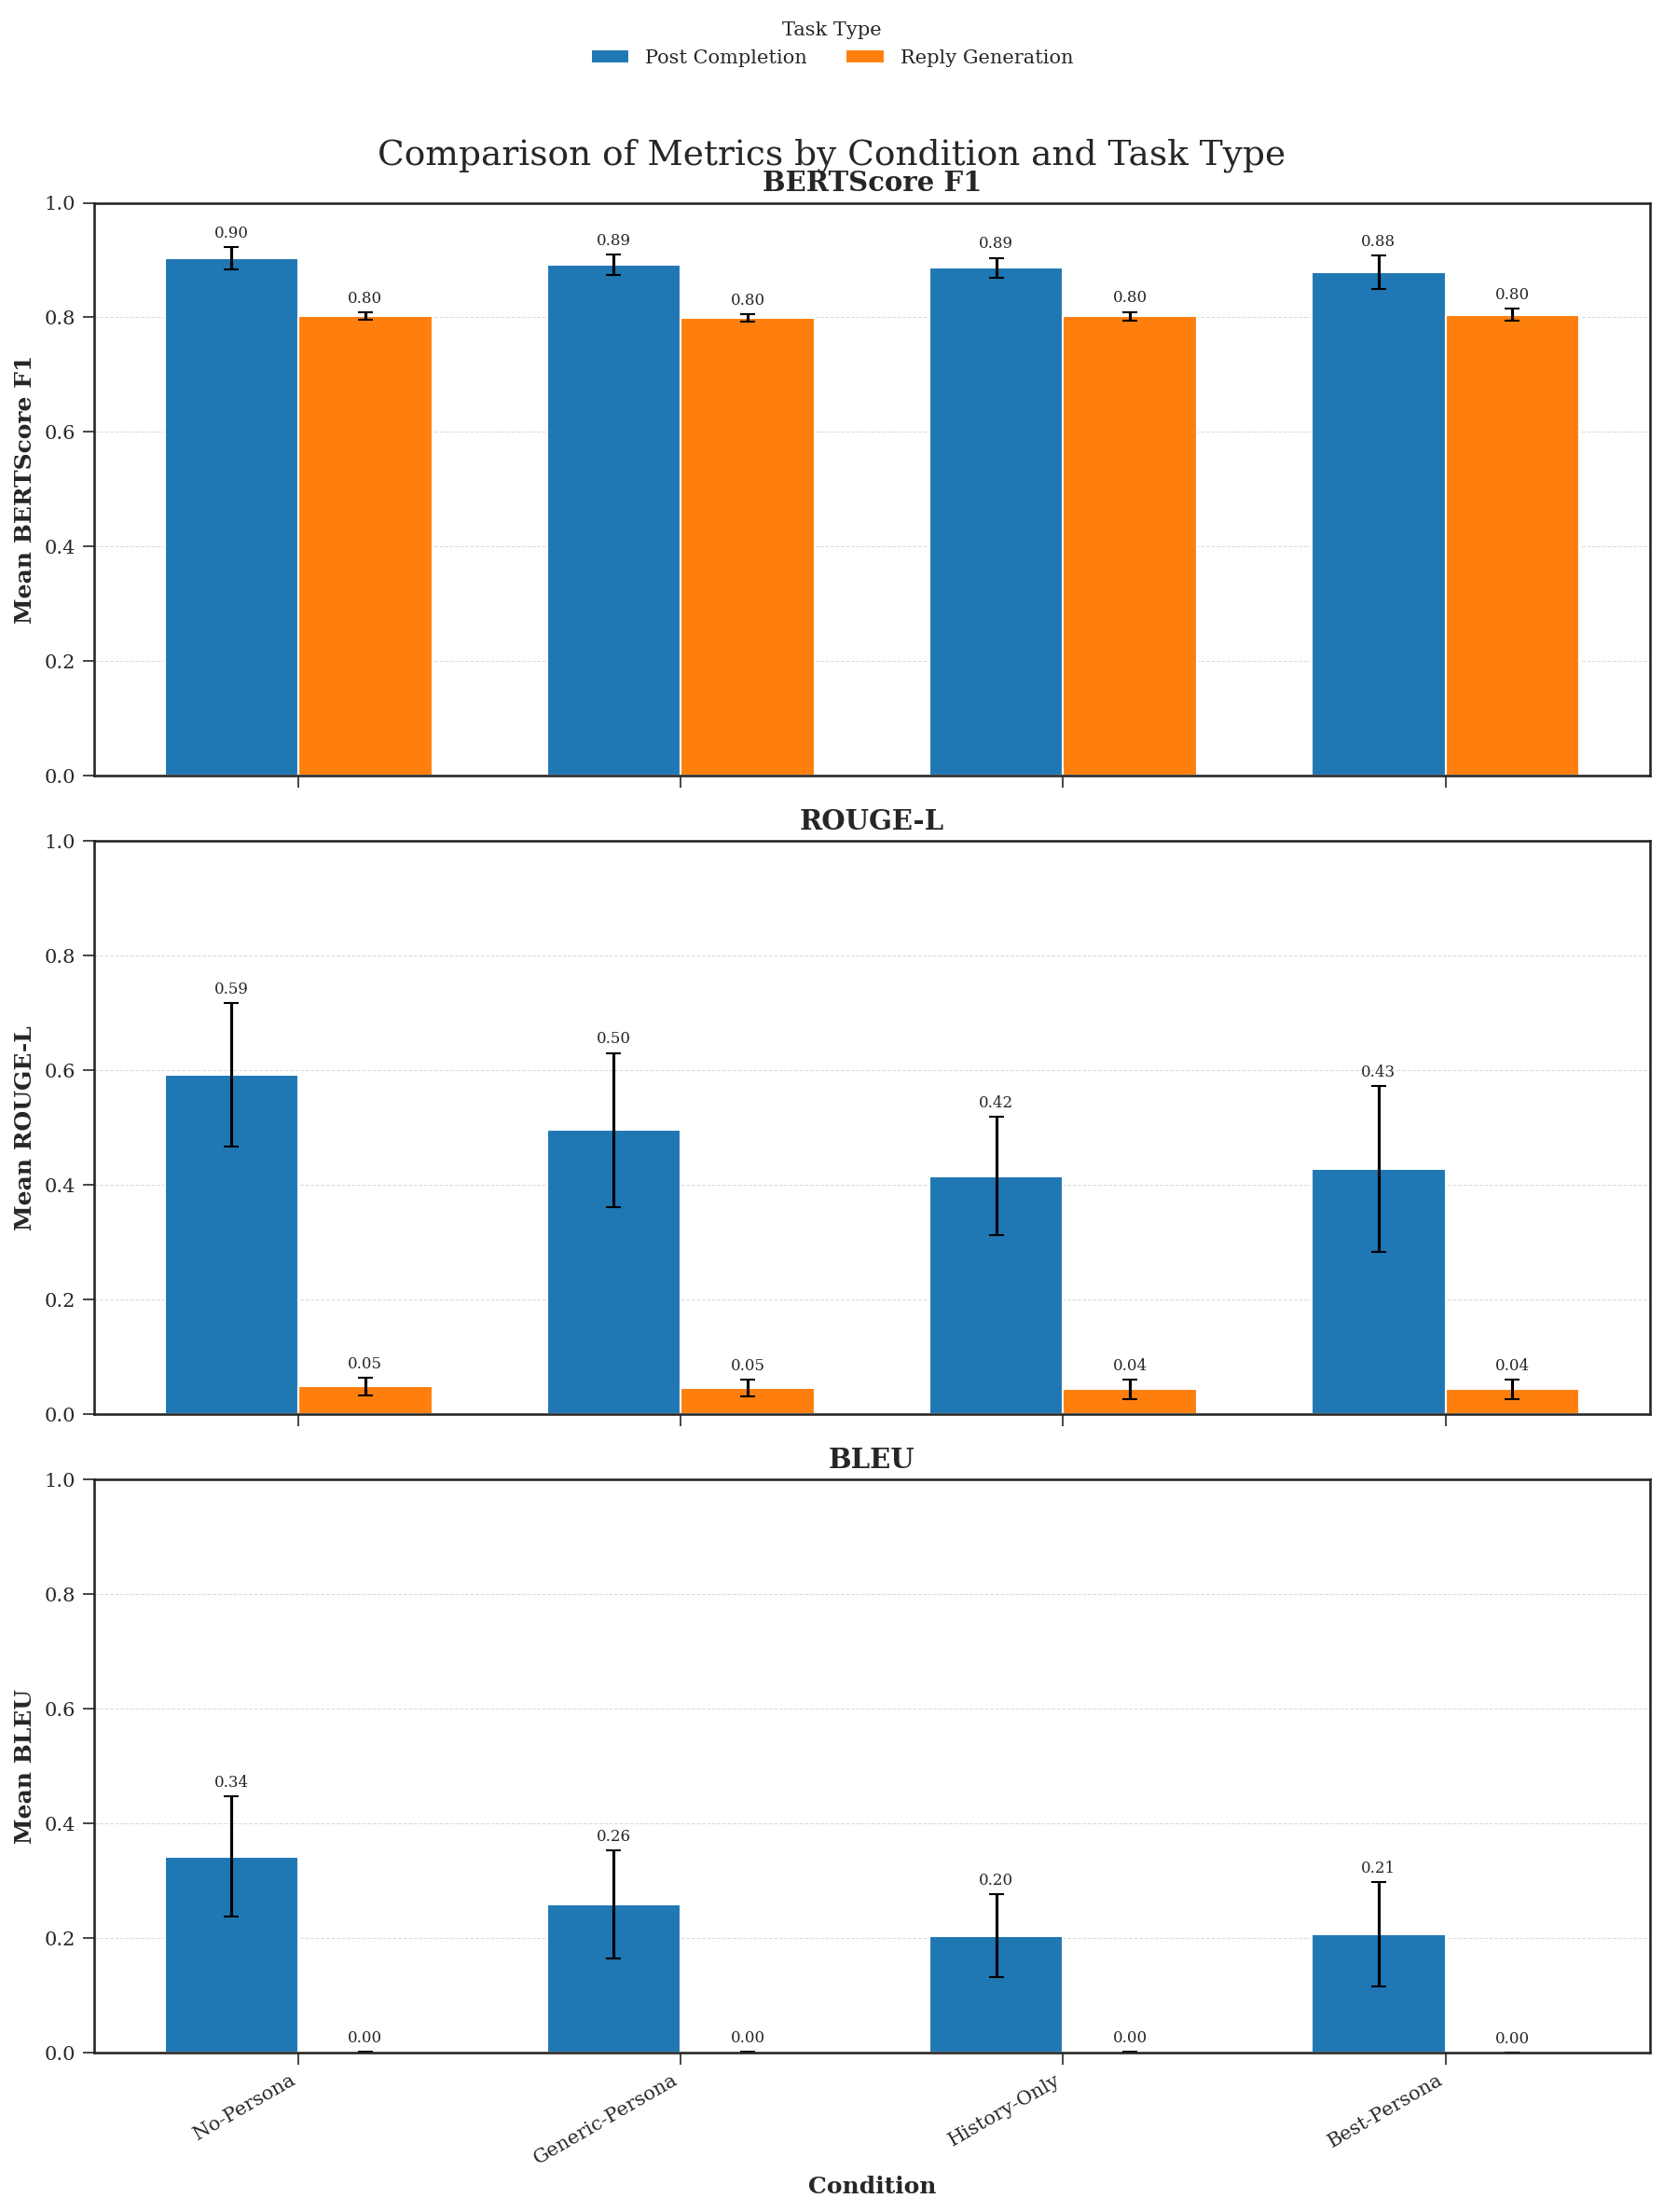

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
# Make sure to update this path to your file's location
df = pd.read_csv('/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/baseline_analysis_v3/Vergleiche_descriptive_statistics_by_task.csv')

# Set plot style
plt.style.use('seaborn-v0_8-ticks')
plt.rcParams['font.family'] = 'serif'

# --- Order conditions by performance ---
mean_performance = df.groupby('condition')['bertscore_f1_mean'].mean().sort_values(ascending=False)
condition_order = mean_performance.index.tolist()
task_order = sorted(df['task_type'].unique())

# --- Plotting Setup ---
x_positions = np.arange(len(condition_order))
bar_width = 0.35
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)
fig.suptitle('Comparison of Metrics by Condition and Task Type', fontsize=18, y=0.93) # Lowered title slightly

# Define metrics and titles to loop over
metrics_to_plot = {
    'bertscore_f1': 'BERTScore F1',
    'rouge_l': 'ROUGE-L',
    'bleu': 'BLEU'
}

# --- Main Plotting Loop ---
for ax, (metric_key, title) in zip(axes, metrics_to_plot.items()):
    mean_col = f'{metric_key}_mean'
    std_col = f'{metric_key}_std'
    
    for i, task in enumerate(task_order):
        offset = bar_width * (i - (len(task_order) - 1) / 2)
        task_data = df[df['task_type'] == task].set_index('condition').loc[condition_order]
        
        bars = ax.bar(
            x_positions + offset,
            task_data[mean_col],
            width=bar_width,
            label=task,
            yerr=task_data[std_col],
            capsize=4
        )
        
        ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=8)

    ax.set_title(title, fontsize=14)
    ax.set_ylabel(f'Mean {title}')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # --- CHANGE 1: Set all y-axes to be from 0 to 1 ---
    ax.set_ylim(0, 1.0)


# --- Final Touches ---
plt.xticks(x_positions, condition_order, rotation=30, ha='right')
axes[2].set_xlabel('Condition', fontsize=12)

# --- CHANGE 2: Move legend to be a horizontal bar above the title ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    title='Task Type',
    loc='upper center',            # Position the legend relative to the anchor
    bbox_to_anchor=(0.5, 0.99),    # Anchor point at top-center of the figure
    ncol=len(task_order),          # Display items horizontally
    frameon=False,                 # Remove the legend box frame
    fontsize='medium'
)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for suptitle and legend
plt.savefig('apa_formatted_plot_final.png', dpi=300, bbox_inches='tight')

plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

try:
    # --- Load Data ---
    print("Loading raw data files...")
    df_baseline = pd.read_csv('/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/baseline_analysis_v3/baseline_results_by_task.csv')
    df_overall = pd.read_csv('/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/baseline_analysis_v3/debug_overall_results.csv')
    print("Files loaded successfully.")

    # --- Analysis 1: Performance by Task ---
    print("Analyzing performance by task...")
    summary_by_task = df_baseline.groupby(['condition', 'task_type']).agg(
        bertscore_f1_mean=('bertscore_f1', 'mean'),
        bertscore_f1_std=('bertscore_f1', 'std'),
        rouge_l_mean=('rouge_l', 'mean'),
        rouge_l_std=('rouge_l', 'std'),
        bleu_mean=('bleu', 'mean'),
        bleu_std=('bleu', 'std')
    ).reset_index()

    # --- Analysis 2: Overall Performance ---
    print("Analyzing overall performance...")
    summary_overall = df_overall.groupby('condition').agg(
        bertscore_f1_mean=('bertscore_f1', 'mean'),
        bertscore_f1_std=('bertscore_f1', 'std'),
        rouge_l_mean=('rouge_l', 'mean'),
        rouge_l_std=('rouge_l', 'std'),
        bleu_mean=('bleu', 'mean'),
        bleu_std=('bleu', 'std')
    ).reset_index()

    # --- APA Table Formatting ---
    print("Generating APA-formatted summary table...")
    summary_overall['task_type'] = 'Overall'
    apa_table_df = pd.concat([summary_by_task, summary_overall], ignore_index=True)
    apa_table_df = apa_table_df[['condition', 'task_type', 'bertscore_f1_mean', 'bertscore_f1_std', 'rouge_l_mean', 'rouge_l_std', 'bleu_mean', 'bleu_std']]

    condition_order = ['Best-Persona', 'Generic-Persona', 'No-Persona', 'History-Only']
    task_order = ['Post Completion', 'Reply Generation', 'Overall']
    apa_table_df['condition'] = pd.Categorical(apa_table_df['condition'], categories=condition_order, ordered=True)
    apa_table_df['task_type'] = pd.Categorical(apa_table_df['task_type'], categories=task_order, ordered=True)
    apa_table_df = apa_table_df.sort_values(['condition', 'task_type'])

    apa_table_df.columns = [
        'Condition', 'Task Type', 'BERTScore F1 (M)', 'BERTScore F1 (SD)',
        'ROUGE-L (M)', 'ROUGE-L (SD)', 'BLEU (M)', 'BLEU (SD)'
    ]
    
    # Save the table to a CSV file
    apa_table_df.to_csv('apa_summary_table.csv', index=False)
    print("SUCCESS: 'apa_summary_table.csv' has been saved.")


    # --- PLOTTING ---
    plt.style.use('seaborn-v0_8-ticks')
    plt.rcParams['font.family'] = 'serif'

    # --- Plot 1: Performance by Task Type ---
    print("Generating Figure 1: Performance by Task Type...")
    perf_order = summary_overall.sort_values('bertscore_f1_mean', ascending=False)['condition'].tolist()
    task_plot_order = sorted(df_baseline['task_type'].unique())
    x_pos = np.arange(len(perf_order))
    bar_width = 0.35
    fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)
    metrics_to_plot = {'bertscore_f1': 'BERTScore F1', 'rouge_l': 'ROUGE-L', 'bleu': 'BLEU'}
    fig.suptitle('Figure 2\nPerformance Metrics by Condition and Task Type', fontsize=16, y=0.98)

    for ax, (metric_key, title) in zip(axes, metrics_to_plot.items()):
        mean_col = f'{metric_key}_mean'
        std_col = f'{metric_key}_std'
        for i, task in enumerate(task_plot_order):
            offset = bar_width * (i - (len(task_plot_order) - 1) / 2)
            task_data = summary_by_task[summary_by_task['task_type'] == task].set_index('condition').loc[perf_order]
            ax.bar(x_pos + offset, task_data[mean_col], width=bar_width, label=task, yerr=task_data[std_col], capsize=4)
        ax.set_title(title)
        ax.set_ylabel(f'Mean {title}')
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)
        ax.set_ylim(0, 1.0)

    plt.xticks(x_pos, perf_order, rotation=15, ha='right')
    axes[2].set_xlabel('Condition')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Task Type', loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=len(task_plot_order), frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig('figure_2_performance_by_task.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    print("SUCCESS: 'figure_1_performance_by_task.png' has been saved.")

    # --- Plot 2: Overall Performance ---
    print("Generating Figure 2: Overall Performance...")
    fig_overall, ax_overall = plt.subplots(figsize=(10, 6))
    overall_perf_order = summary_overall.sort_values('bertscore_f1_mean', ascending=False)
    bars = ax_overall.bar(overall_perf_order['condition'], overall_perf_order['bertscore_f1_mean'], yerr=overall_perf_order['bertscore_f1_std'], capsize=5, color='skyblue')
    ax_overall.bar_label(bars, fmt='%.3f', padding=3)
    ax_overall.set_title('Figure 2\nOverall Mean BERTScore F1 Performance by Condition', fontsize=14)
    ax_overall.set_ylabel('Mean BERTScore F1')
    ax_overall.set_xlabel('Condition')
    ax_overall.set_ylim(0, 1.0)
    ax_overall.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax_overall.set_axisbelow(True)
    plt.tight_layout()
    plt.savefig('figure_2_overall_performance.png', dpi=300, bbox_inches='tight')
    plt.close(fig_overall)
    print("SUCCESS: 'figure_2_overall_performance.png' has been saved.")

except FileNotFoundError as e:
    print(f"\nERROR: Could not find a required CSV file.")
    print(f"Please make sure '{e.filename}' is in the same directory as the script.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Loading raw data files...
Files loaded successfully.
Analyzing performance by task...
Analyzing overall performance...
Generating APA-formatted summary table...
SUCCESS: 'apa_summary_table.csv' has been saved.
Generating Figure 1: Performance by Task Type...
SUCCESS: 'figure_1_performance_by_task.png' has been saved.
Generating Figure 2: Overall Performance...
SUCCESS: 'figure_2_overall_performance.png' has been saved.


In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv('/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/baseline_analysis_v3/Vergleiche_descriptive_statistics_by_task.csv')

# Get all unique values from the 'condition' column
unique_conditions = df['condition'].unique()

# Print the result
print("Gefundene 'conditions' in der Datei:")
print(unique_conditions)

Gefundene 'conditions' in der Datei:
['Best-Persona' 'Generic-Persona' 'History-Only' 'No-Persona']


In [22]:
# Standalone script to generate the iterative comparison plot (Figure 1)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---

# --- CORRECT: Please adjust this path ---
# Enter the full, absolute path to your 'results' folder here.
RESULTS_DIR = '/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/results'

# Definition of the color scheme and legend names.
STYLE_CONFIG = {
    'run_r50_all_metrics': {'color': '#1f77b4', 'label': 'All Metrics'},
    'run_r50_bertscore': {'color': '#ff7f0e', 'label': 'BERTScore'},
    'run_r50_bleu_only': {'color': '#2ca02c', 'label': 'BLEU'},
    'run_r50_perplexity_only': {'color': '#d62728', 'label': 'Perplexity'},
    'run_r50_rouge_1': {'color': '#9467bd', 'label': 'ROUGE-1'}
}

# --- Helper Functions ---

def set_apa_style():
    """Applies basic APA formatting guidelines to Matplotlib plots."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'axes.labelweight': 'bold',
        'axes.titleweight': 'bold',
        'grid.color': '#dddddd',
        'grid.linestyle': '--',
        'grid.linewidth': 0.5,
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.5,
        'xtick.major.size': 5,
        'ytick.major.size': 5,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.labelsize': 12,
        'legend.fontsize': 10,
        'figure.dpi': 150
    })

def load_iterative_data():
    """Loads and prepares the data from all iterative experiments."""
    all_dfs = []
    for prefix, config in STYLE_CONFIG.items():
        folder_path = os.path.join(RESULTS_DIR, f"{prefix}_final_analysis")
        
        if os.path.isdir(folder_path):
            try:
                # --- CORRECT: Smart file search ---
                csv_files = [f for f in os.listdir(folder_path) if f.endswith('_aggregated_task_aware_statistics.csv')]
                if not csv_files:
                    print(f"Warning: No aggregated CSV file found in {folder_path}.")
                    continue
                
                file_path = os.path.join(folder_path, csv_files[0])
                df = pd.read_csv(file_path, header=[0, 1])
                
                # Calculate Standard Error of the Mean (SEM) for error bands
                for metric in ['replies_mean_bertscore_f1', 'posts_content_accuracy']:
                    mean_col = (metric, 'mean')
                    std_col = (metric, 'std')
                    count_col = (metric, 'count')
                    sem_col = (metric, 'sem')
                    if all(c in df.columns for c in [mean_col, std_col, count_col]):
                        df[sem_col] = df[std_col] / np.sqrt(df[count_col].where(df[count_col] > 0))

                df['prefix'] = prefix
                df['round'] = df.index
                all_dfs.append(df)
            except Exception as e:
                print(f"Warning: Could not load or process file: {file_path}\nError: {e}")
        else:
            print(f"Warning: Directory not found: {folder_path}")
            
    if not all_dfs:
        return pd.DataFrame()
        
    return pd.concat(all_dfs, ignore_index=True)

def plot_iterative_comparison(df):
    """Creates the line plot to compare feedback strategies."""
    if df.empty:
        print("Error: No data available for the iterative comparison plot.")
        return

    set_apa_style()
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Round of Iteration')
    ax1.set_ylabel('Quality of Replies (BERTScore F1)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    # --- CHANGE: Adjusted y-axis limits ---
    ax1.set_ylim(0, 1.0)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Quality of Posts (Content Accuracy)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    # --- CHANGE: Adjusted y-axis limits ---
    ax2.set_ylim(0, 1.0)

    for prefix, group in df.groupby('prefix'):
        config = STYLE_CONFIG.get(prefix, {})
        color = config.get('color', 'gray')
        label = config.get('label', prefix)
        
        # Replies (solid line)
        mean_col_reply = ('replies_mean_bertscore_f1', 'mean')
        sem_col_reply = ('replies_mean_bertscore_f1', 'sem')
        if mean_col_reply in group.columns:
            mean_vals = group[mean_col_reply]
            ax1.plot(group['round'], mean_vals, color=color, linestyle='-', label=f'{label} (Replies)')
            if sem_col_reply in group.columns:
                sem_vals = group[sem_col_reply].fillna(0)
                ax1.fill_between(group['round'], mean_vals - sem_vals, mean_vals + sem_vals, color=color, alpha=0.15)

        # Posts (dashed line)
        mean_col_post = ('posts_content_accuracy', 'mean')
        sem_col_post = ('posts_content_accuracy', 'sem')
        if mean_col_post in group.columns:
            mean_vals = group[mean_col_post]
            ax2.plot(group['round'], mean_vals, color=color, linestyle='--', label=f'{label} (Posts)')
            if sem_col_post in group.columns:
                sem_vals = group[sem_col_post].fillna(0)
                ax2.fill_between(group['round'], mean_vals - sem_vals, mean_vals + sem_vals, color=color, alpha=0.1)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', frameon=True, facecolor='white', framealpha=0.8)

    fig.tight_layout()
    # Save in the execution directory
    save_path = 'figure_1_iterative_comparison.png'
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Figure 1 (Iterative Comparison) has been saved as '{os.path.abspath(save_path)}'.")


if __name__ == "__main__":
    if not os.path.isdir(RESULTS_DIR):
        print(f"ERROR: The main results directory was not found: '{RESULTS_DIR}'")
        print("Please adjust the 'RESULTS_DIR' variable at the beginning of the script.")
    else:
        # Create Figure 1
        iterative_data = load_iterative_data()
        plot_iterative_comparison(iterative_data)
        
        print("\nPlot created successfully.")

Figure 1 (Iterative Comparison) has been saved as '/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/figure_1_iterative_comparison.png'.

Plot created successfully.


In [26]:
def plot_replies_comparison_enhanced(df):
    """Creates an enhanced line plot to compare feedback strategies for replies."""
    if df.empty:
        print("Error: No data available for the replies comparison plot.")
        return

    set_apa_style()
    fig, ax = plt.subplots(figsize=(12, 7)) # A slightly wider figure can be better

    # --- 1. Add Title and Subtitle ---
    ax.set_title('Reply Quality Improves with Iterative Feedback', fontsize=16, pad=20, weight='bold')
    ax.text(x=0, y=1.05, s='Comparing BERTScore F1 across different feedback strategies over 5 rounds', 
            transform=ax.transAxes, ha='left', fontsize=12, alpha=0.8)

    ax.set_xlabel('Feedback & Refinement Round')
    ax.set_ylabel('Quality of Replies (BERTScore F1)')
    ax.set_ylim(0.7, 0.9) # Zooming in can be better if all data is in a narrow range

    for prefix, group in df.groupby('prefix'):
        config = STYLE_CONFIG.get(prefix, {})
        color = config.get('color', 'gray')
        label = config.get('label', prefix)
        
        mean_col_reply = ('replies_mean_bertscore_f1', 'mean')
        sem_col_reply = ('replies_mean_bertscore_f1', 'sem')

        if mean_col_reply in group.columns:
            # --- 2. Emphasize the most important line ---
            is_highlight = (label == 'All Metrics')
            linewidth = 3.0 if is_highlight else 1.5
            alpha = 1.0 if is_highlight else 0.8
            z_order = 5 if is_highlight else 2

            mean_vals = group[mean_col_reply]
            ax.plot(group['round'], mean_vals, color=color, linestyle='-', 
                    label=label, linewidth=linewidth, zorder=z_order, alpha=alpha)
            
            if sem_col_reply in group.columns:
                sem_vals = group[sem_col_reply].fillna(0)
                ax.fill_between(group['round'], mean_vals - sem_vals, mean_vals + sem_vals, 
                                color=color, alpha=0.1)

    # --- 3. Annotate a key finding ---
    all_metrics_df = df[df['prefix'] == 'run_r50_all_metrics']
    if not all_metrics_df.empty:
        last_round = all_metrics_df['round'].iloc[-1]
        last_score = all_metrics_df[('replies_mean_bertscore_f1', 'mean')].iloc[-1]
        ax.annotate(f'Best Performer: {last_score:.3f}',
                    xy=(last_round, last_score),
                    xytext=(last_round - 2.5, last_score - 0.03),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                    bbox=dict(boxstyle="round,pad=0.3", fc="#ff7f0e", ec="black", lw=1, alpha=0.7))

    # --- 4. Reduce Chart Junk ---
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(loc='lower right', frameon=True, facecolor='white', framealpha=0.9, title='Feedback Strategy')
    fig.tight_layout()
    
    save_path = 'figure_1_replies_comparison_enhanced.png'
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Enhanced replies plot has been saved as '{os.path.abspath(save_path)}'.")

# You would call this new function in your main block
# if __name__ == "__main__":
#     iterative_data = load_iterative_data()
#     plot_replies_comparison_enhanced(iterative_data)

In [25]:
# Standalone script to generate the iterative comparison plot for POSTS

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---

# --- CORRECT: Please adjust this path ---
# Enter the full, absolute path to your 'results' folder here.
RESULTS_DIR = '/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/results'

# Definition of the color scheme and legend names.
STYLE_CONFIG = {
    'run_r50_all_metrics': {'color': '#1f77b4', 'label': 'All Metrics'},
    'run_r50_bertscore': {'color': '#ff7f0e', 'label': 'BERTScore'},
    'run_r50_bleu_only': {'color': '#2ca02c', 'label': 'BLEU'},
    'run_r50_perplexity_only': {'color': '#d62728', 'label': 'Perplexity'},
    'run_r50_rouge_1': {'color': '#9467bd', 'label': 'ROUGE-1'}
}

# --- Helper Functions ---

def set_apa_style():
    """Applies basic APA formatting guidelines to Matplotlib plots."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'axes.labelweight': 'bold',
        'axes.titleweight': 'bold',
        'grid.color': '#dddddd',
        'grid.linestyle': '--',
        'grid.linewidth': 0.5,
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.5,
        'xtick.major.size': 5,
        'ytick.major.size': 5,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.labelsize': 12,
        'legend.fontsize': 10,
        'figure.dpi': 150
    })

def load_iterative_data():
    """Loads and prepares the data from all iterative experiments."""
    all_dfs = []
    for prefix, config in STYLE_CONFIG.items():
        folder_path = os.path.join(RESULTS_DIR, f"{prefix}_final_analysis")
        
        if os.path.isdir(folder_path):
            try:
                csv_files = [f for f in os.listdir(folder_path) if f.endswith('_aggregated_task_aware_statistics.csv')]
                if not csv_files:
                    print(f"Warning: No aggregated CSV file found in {folder_path}.")
                    continue
                
                file_path = os.path.join(folder_path, csv_files[0])
                df = pd.read_csv(file_path, header=[0, 1])
                
                for metric in ['replies_mean_bertscore_f1', 'posts_content_accuracy']:
                    mean_col = (metric, 'mean')
                    std_col = (metric, 'std')
                    count_col = (metric, 'count')
                    sem_col = (metric, 'sem')
                    if all(c in df.columns for c in [mean_col, std_col, count_col]):
                        df[sem_col] = df[std_col] / np.sqrt(df[count_col].where(df[count_col] > 0))

                df['prefix'] = prefix
                df['round'] = df.index
                all_dfs.append(df)
            except Exception as e:
                print(f"Warning: Could not load or process file: {file_path}\nError: {e}")
        else:
            print(f"Warning: Directory not found: {folder_path}")
            
    if not all_dfs:
        return pd.DataFrame()
        
    return pd.concat(all_dfs, ignore_index=True)

def plot_posts_comparison(df):
    """Creates the line plot to compare feedback strategies for posts."""
    if df.empty:
        print("Error: No data available for the posts comparison plot.")
        return

    set_apa_style()
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_xlabel('Round of Iteration')
    ax.set_ylabel('Quality of Posts (Content Accuracy)')
    ax.set_ylim(0, 1.0)

    for prefix, group in df.groupby('prefix'):
        config = STYLE_CONFIG.get(prefix, {})
        color = config.get('color', 'gray')
        label = config.get('label', prefix)
        
        mean_col_post = ('posts_content_accuracy', 'mean')
        sem_col_post = ('posts_content_accuracy', 'sem')
        if mean_col_post in group.columns:
            mean_vals = group[mean_col_post]
            ax.plot(group['round'], mean_vals, color=color, linestyle='--', label=label)
            if sem_col_post in group.columns:
                sem_vals = group[sem_col_post].fillna(0)
                ax.fill_between(group['round'], mean_vals - sem_vals, mean_vals + sem_vals, color=color, alpha=0.15)

    ax.legend(loc='lower right', frameon=True, facecolor='white', framealpha=0.8)
    fig.tight_layout()
    
    save_path = 'figure_2_posts_comparison.png'
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Posts comparison plot has been saved as '{os.path.abspath(save_path)}'.")


if __name__ == "__main__":
    if not os.path.isdir(RESULTS_DIR):
        print(f"ERROR: The main results directory was not found: '{RESULTS_DIR}'")
        print("Please adjust the 'RESULTS_DIR' variable at the beginning of the script.")
    else:
        iterative_data = load_iterative_data()
        plot_posts_comparison(iterative_data)
        
        print("\nPosts plot created successfully.")

Posts comparison plot has been saved as '/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/figure_2_posts_comparison.png'.

Posts plot created successfully.


In [36]:
# Standalone script to generate a final, comprehensive performance report

import os
import pandas as pd
import numpy as np

# --- Configuration ---

# --- CORRECT: Please adjust this path ---
# Enter the full, absolute path to your 'results' folder here.
RESULTS_DIR = '/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/results'

# Definition of the color scheme and legend names.
STYLE_CONFIG = {
    'run_r50_all_metrics': {'color': '#1f77b4', 'label': 'All Metrics'},
    'run_r50_bertscore': {'color': '#ff7f0e', 'label': 'BERTScore'},
    'run_r50_bleu_only': {'color': '#2ca02c', 'label': 'BLEU'},
    'run_r50_perplexity_only': {'color': '#d62728', 'label': 'Perplexity'},
    'run_r50_rouge_1': {'color': '#9467bd', 'label': 'ROUGE-1'}
}

# --- Data Loading Function ---

def load_iterative_data():
    """Loads and prepares the data, flattening column headers for simplicity."""
    all_dfs = []
    for prefix in STYLE_CONFIG.keys():
        folder_path = os.path.join(RESULTS_DIR, f"{prefix}_final_analysis")
        if os.path.isdir(folder_path):
            try:
                csv_files = [f for f in os.listdir(folder_path) if f.endswith('_aggregated_task_aware_statistics.csv')]
                if not csv_files:
                    continue
                file_path = os.path.join(folder_path, csv_files[0])
                df = pd.read_csv(file_path, header=[0, 1])
                df.columns = ['_'.join(col).strip() for col in df.columns.values]
                df['prefix'] = prefix
                df['round'] = df.index
                all_dfs.append(df)
            except Exception as e:
                print(f"Warning: Could not process {file_path}. Error: {e}")
        else:
            print(f"Warning: Directory not found: {folder_path}")

    if not all_dfs:
        return pd.DataFrame()
    return pd.concat(all_dfs, ignore_index=True)

# --- Report Generation Function (MODIFIED) ---

def generate_performance_report(df):
    """Analyzes the simplified DataFrame and prints the final report."""
    if df.empty:
        print("Cannot generate report because no data was loaded.")
        return

    # --- Data Preparation ---
    replies_col = 'replies_mean_bertscore_f1_mean'
    posts_col = 'posts_content_accuracy_mean'
    df['label'] = df['prefix'].map(lambda p: STYLE_CONFIG.get(p, {}).get('label', p))

    print("=====================================================")
    print("      Iterative Feedback Performance Report          ")
    print("=====================================================")

    # --- Section 1: Best Performer by Round ---
    print("\n## 🏆 Best Performer by Round\n")
    sorted_rounds = sorted(df['round'].unique())
    for round_num in sorted_rounds:
        round_df = df[df['round'] == round_num]
        if round_df.empty: continue
        print(f"--- Round {round_num} ---")
        valid_replies = round_df.dropna(subset=[replies_col])
        if not valid_replies.empty:
            best_row = valid_replies.loc[valid_replies[replies_col].idxmax()]
            print(f"  Replies (BERTScore F1): '{best_row['label']}' was best with a score of {best_row[replies_col]:.4f}")
        else:
            print("  Replies (BERTScore F1): No valid data available for this round.")
        valid_posts = round_df.dropna(subset=[posts_col])
        if not valid_posts.empty:
            best_row = valid_posts.loc[valid_posts[posts_col].idxmax()]
            print(f"  Posts (Content Accuracy): '{best_row['label']}' was best with a score of {best_row[posts_col]:.4f}\n")
        else:
            print("  Posts (Content Accuracy): No valid data available for this round.\n")

    # --- Section 2: NEW Peak Performance Summary ---
    print("\n## 🚀 Peak Performance Summary\n")
    valid_df = df.dropna(subset=[replies_col, posts_col])

    print("--- Overall Best Performance ---\n")
    if not valid_df.empty:
        best_reply_overall = valid_df.loc[valid_df[replies_col].idxmax()]
        print(f"  Replies: '{best_reply_overall['label']}' achieved the highest score of {best_reply_overall[replies_col]:.4f} in round {best_reply_overall['round']}.")
        best_post_overall = valid_df.loc[valid_df[posts_col].idxmax()]
        print(f"  Posts:   '{best_post_overall['label']}' achieved the highest score of {best_post_overall[posts_col]:.4f} in round {best_post_overall['round']}.\n")

    print("--- Peak Performance per Strategy ---\n")
    for label, group in valid_df.groupby('label'):
        best_reply = group.loc[group[replies_col].idxmax()]
        best_post = group.loc[group[posts_col].idxmax()]
        print(f"  Strategy: '{label}'")
        print(f"    - Replies peak: {best_reply[replies_col]:.4f} (in round {best_reply['round']})")
        print(f"    - Posts peak:   {best_post[posts_col]:.4f} (in round {best_post['round']})\n")


    # --- Section 3: FIXED Improvement Analysis ---
    print("\n## 📈 Improvement Analysis (Initial vs. Peak)\n")
    for prefix, group in df.groupby('prefix'):
        label = STYLE_CONFIG.get(prefix, {}).get('label', prefix)
        
        # --- FIX: Use the valid_group to get the initial score ---
        # This ensures the calculation starts from the first round with actual data.
        valid_group = group.dropna(subset=[replies_col, posts_col]).sort_values('round')
        if valid_group.empty:
            print(f"--- Strategy: '{label}' ---")
            print("  No valid data to calculate improvement.\n")
            continue

        initial_reply_score = valid_group.iloc[0][replies_col]
        initial_reply_round = valid_group.iloc[0]['round']
        best_reply_score = valid_group[replies_col].max()
        reply_improvement = best_reply_score - initial_reply_score

        initial_post_score = valid_group.iloc[0][posts_col]
        initial_post_round = valid_group.iloc[0]['round']
        best_post_score = valid_group[posts_col].max()
        post_improvement = best_post_score - initial_post_score

        print(f"--- Strategy: '{label}' ---")
        print(f"  Replies Improvement: {reply_improvement:+.4f} (from {initial_reply_score:.4f} in round {initial_reply_round} to {best_reply_score:.4f})")
        print(f"  Posts Improvement:   {post_improvement:+.4f} (from {initial_post_score:.4f} in round {initial_post_round} to {best_post_score:.4f})\n")

    print("=====================================================")
    print("                 End of Report                   ")
    print("=====================================================")

if __name__ == "__main__":
    if not os.path.isdir(RESULTS_DIR):
        print(f"ERROR: The main results directory was not found: '{RESULTS_DIR}'")
        print("Please adjust the 'RESULTS_DIR' variable at the beginning of the script.")
    else:
        iterative_data = load_iterative_data()
        generate_performance_report(iterative_data)

      Iterative Feedback Performance Report          

## 🏆 Best Performer by Round

--- Round 0 ---
  Replies (BERTScore F1): No valid data available for this round.
  Posts (Content Accuracy): No valid data available for this round.

--- Round 1 ---
  Replies (BERTScore F1): 'All Metrics' was best with a score of 0.8191
  Posts (Content Accuracy): 'BERTScore' was best with a score of 0.7143

--- Round 2 ---
  Replies (BERTScore F1): 'BERTScore' was best with a score of 0.8231
  Posts (Content Accuracy): 'ROUGE-1' was best with a score of 0.7127

--- Round 3 ---
  Replies (BERTScore F1): 'ROUGE-1' was best with a score of 0.8317
  Posts (Content Accuracy): 'ROUGE-1' was best with a score of 0.7220

--- Round 4 ---
  Replies (BERTScore F1): 'BLEU' was best with a score of 0.8344
  Posts (Content Accuracy): 'BERTScore' was best with a score of 0.8667

--- Round 5 ---
  Replies (BERTScore F1): 'All Metrics' was best with a score of 0.8330
  Posts (Content Accuracy): 'BERTScore' was best 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

try:
    # --- Load the New Dataset ---
    print("Loading 'combined_baseline_metrics.csv'...")
    df = pd.read_csv('/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/results/baseline_comparative_analysis/combined_baseline_metrics.csv')
    print("File loaded successfully.")
    print("Checking for negative standard deviations...")
    std_columns = [col for col in summary_df.columns if col.endswith('_std')]
    for col in std_columns:
        negative_stds = summary_df[col] < 0
        if negative_stds.any():
            print(f"WARNING: Negative std values found in {col}:")
            print(summary_df.loc[negative_stds, col])
        else:
            print(f"✓ {col} - all positive")

    # --- 1. APPLY NAME AND COLOR MAPPINGS ---
    name_mapping = {
        'run_r50_all_metrics': 'All Metrics',
        'run_r50_bertscore': 'BERTScore only',
        'run_r50_bleu_only': 'BLEU only',
        'run_r50_perplexity_only': 'Perplexity only',
        'run_r50_rouge_1': 'ROUGE only'
    }
    
    color_mapping = {
        'All Metrics': '#1f77b4',
        'BERTScore only': '#ff7f0e',
        'BLEU only': '#2ca02c',
        'Perplexity only': '#d62728',
        'ROUGE only': '#9467bd'
    }

    # Apply the mapping to the 'condition' column
    df['condition'] = df['condition'].map(name_mapping)
    # Drop any rows that didn't match the mapping
    df.dropna(subset=['condition'], inplace=True)


    # --- Analysis & Table Generation ---
    post_metrics = ['posts_semantic_similarity', 'posts_content_accuracy', 'posts_format_compliance', 'posts_exact_match_rate']
    reply_metrics = ['replies_mean_bertscore_f1', 'replies_mean_rouge1', 'replies_mean_bleu', 'replies_mean_perplexity']
    all_metrics = post_metrics + reply_metrics
    
    print("Calculating descriptive statistics...")
    agg_dict = {metric: ['mean', 'std'] for metric in all_metrics}
    summary_df = df.groupby('condition').agg(agg_dict)
    summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
    
    summary_df.to_csv('new_metrics_summary_table.csv')
    print("SUCCESS: 'new_metrics_summary_table.csv' has been saved.")

    # --- Plotting Setup ---
    plt.style.use('seaborn-v0_8-ticks')
    plt.rcParams['font.family'] = 'serif'

    # --- PLOT 1: POST METRICS ---
    print("Generating Figure 3 for Post Metrics...")
    post_order = summary_df.sort_values('posts_semantic_similarity_mean', ascending=False).index
    fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10))
    fig1.suptitle('Figure 3: Comparison of Post Generation Metrics by Condition', fontsize=16, y=0.98)
    axes1 = axes1.flatten()

    for ax, metric in zip(axes1, post_metrics):
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'
        means = summary_df.loc[post_order, mean_col]
        stds = summary_df.loc[post_order, std_col]
        # Use the color mapping
        colors = means.index.map(color_mapping)
        ax.bar(means.index, means, yerr=stds, capsize=4, color=colors)
        ax.set_title(metric.replace('_', ' ').title())
        ax.tick_params(axis='x', rotation=30, labelsize=9)
        ax.set_ylabel('Mean Score')
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylim(0, 1.0)
    
    # Add a custom legend
    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]
    fig1.legend(handles=legend_patches, loc='upper center', ncol=len(color_mapping), bbox_to_anchor=(0.5, 0.94), frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig('figure_3_post_metrics.png', dpi=300)
    plt.close(fig1)
    print("SUCCESS: 'figure_3_post_metrics.png' has been saved.")

    # --- PLOT 2: REPLY METRICS ---
    print("Generating Figure 4 for Reply Metrics...")
    reply_order = summary_df.sort_values('replies_mean_bertscore_f1_mean', ascending=False).index
    fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))
    fig2.suptitle('Figure 4: Comparison of Reply Generation Metrics by Condition', fontsize=16, y=0.98)
    axes2 = axes2.flatten()

    for ax, metric in zip(axes2, reply_metrics):
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'
        means = summary_df.loc[reply_order, mean_col]
        stds = summary_df.loc[reply_order, std_col]
        colors = means.index.map(color_mapping)
        
        # Cap error bars to prevent negative values
        if metric == 'replies_mean_perplexity':
            lower_errors = np.minimum(stds, means)  # Don't let lower error bars go below zero
            ax.bar(means.index, means, yerr=[lower_errors, stds], capsize=4, color=colors)
        else:
            ax.bar(means.index, means, yerr=stds, capsize=4, color=colors)
        ax.set_title(metric.replace('_', ' ').title())
        ax.tick_params(axis='x', rotation=30, labelsize=9)
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        
        if metric == 'replies_mean_perplexity':
            ax.set_ylabel('Mean Perplexity (Lower is Better)')
        else:
            ax.set_ylabel('Mean Score')
            ax.set_ylim(0, 1.0)
            
    # Add a custom legend
    fig2.legend(handles=legend_patches, loc='upper center', ncol=len(color_mapping), bbox_to_anchor=(0.5, 0.94), frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig('figure_4_reply_metrics.png', dpi=300)
    plt.close(fig2)
    print("SUCCESS: 'figure_4_reply_metrics.png' has been saved.")

except FileNotFoundError:
    print("\nERROR: Could not find 'combined_baseline_metrics.csv'.")
    print("Please make sure the CSV file is in the same directory as this script.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Loading 'combined_baseline_metrics.csv'...
File loaded successfully.
Checking for negative standard deviations...
✓ posts_semantic_similarity_std - all positive
✓ posts_content_accuracy_std - all positive
✓ posts_format_compliance_std - all positive
✓ posts_exact_match_rate_std - all positive
✓ replies_mean_bertscore_f1_std - all positive
✓ replies_mean_rouge1_std - all positive
✓ replies_mean_bleu_std - all positive
✓ replies_mean_perplexity_std - all positive
Calculating descriptive statistics...
SUCCESS: 'new_metrics_summary_table.csv' has been saved.
Generating Figure 3 for Post Metrics...
SUCCESS: 'figure_3_post_metrics.png' has been saved.
Generating Figure 4 for Reply Metrics...
SUCCESS: 'figure_4_reply_metrics.png' has been saved.


--- Perplexity Statistics by Strategy ---
                 count        mean          std        min        25%  \
condition                                                               
All Metrics       54.0  715.281736  1214.422121   3.343184  64.460028   
BERTScore only   134.0  490.111429  1614.645309  31.642803  78.796951   
BLEU only        144.0  221.393560   253.887039  20.426198  67.142571   
Perplexity only  167.0  279.050037  1008.808745  27.128490  66.212134   
ROUGE only       120.0  252.277825   390.640357  34.467425  59.272958   

                        50%         75%           max  
condition                                              
All Metrics      153.820861  821.423018   5849.460449  
BERTScore only   135.298532  254.849720  12804.649251  
BLEU only        150.227253  261.365792   1807.004841  
Perplexity only  104.800306  224.330487  12695.027100  
ROUGE only        96.092755  238.188596   2274.406738  


/var/folders/y1/nwn64wsx1zdcpp75s80zznj00000gn/T/ipykernel_42080/594519607.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(



SUCCESS: Plot saved to 'perplexity_distribution_by_strategy.png'


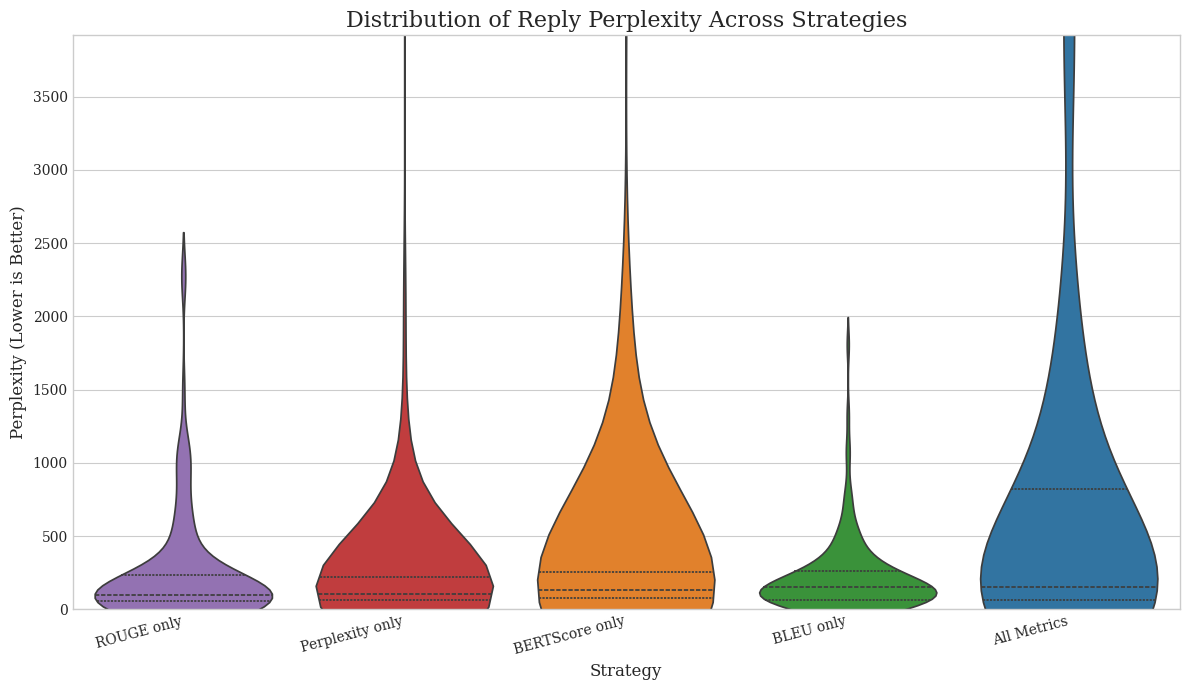

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # Load the dataset
    df = pd.read_csv('/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/results/baseline_comparative_analysis/combined_baseline_metrics.csv')

    # --- 1. Map strategy names and define colors ---
    name_mapping = {
        'run_r50_all_metrics': 'All Metrics',
        'run_r50_bertscore': 'BERTScore only',
        'run_r50_bleu_only': 'BLEU only',
        'run_r50_perplexity_only': 'Perplexity only',
        'run_r50_rouge_1': 'ROUGE only'
    }

    color_mapping = {
        'All Metrics': '#1f77b4',
        'BERTScore only': '#ff7f0e',
        'BLEU only': '#2ca02c',
        'Perplexity only': '#d62728',
        'ROUGE only': '#9467bd'
    }
    
    df['condition'] = df['condition'].map(name_mapping)
    df.dropna(subset=['condition'], inplace=True)

    # --- 2. Calculate Descriptive Statistics for Perplexity ---
    print("--- Perplexity Statistics by Strategy ---")
    perplexity_stats = df.groupby('condition')['replies_mean_perplexity'].describe()
    print(perplexity_stats)

    # --- 3. Create a Violin Plot to Visualize the Spread ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.family'] = 'serif'

    # Order the strategies by median perplexity (lower is better)
    order = perplexity_stats.sort_values('50%').index

    fig, ax = plt.subplots(figsize=(12, 7))

    # UPDATED LINE: Replaced palette='viridis' with your color_mapping dictionary
    sns.violinplot(
        data=df,
        x='condition',
        y='replies_mean_perplexity',
        order=order,
        inner='quartile', 
        palette=color_mapping 
    )

    # Set titles and labels
    ax.set_title('Distribution of Reply Perplexity Across Strategies', fontsize=16)
    ax.set_xlabel('Strategy', fontsize=12)
    ax.set_ylabel('Perplexity (Lower is Better)', fontsize=12)
    plt.xticks(rotation=15, ha='right')

    # Improve readability by limiting the y-axis to the 95th percentile
    p95 = df['replies_mean_perplexity'].quantile(0.99)
    ax.set_ylim(0, p95)

    plt.tight_layout()
    plt.savefig('perplexity_distribution_by_strategy.png', dpi=300)
    print("\nSUCCESS: Plot saved to 'perplexity_distribution_by_strategy.png'")

except FileNotFoundError:
    print("\nERROR: Could not find 'combined_baseline_metrics.csv'.")
    print("Please make sure the CSV file is in the same directory as this script.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

try:
    # --- Load the New Dataset ---
    print("Loading 'combined_real_baseline_metrics.csv'...")
    df = pd.read_csv('/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/results/baseline_comparative_analysis/combined_real_baseline_metrics.csv')
    print("File loaded successfully.")

    # --- Metriken definieren ---
    post_metrics = ['posts_semantic_similarity', 'posts_content_accuracy', 'posts_format_compliance', 'posts_exact_match_rate']
    reply_metrics = ['replies_mean_bertscore_f1', 'replies_mean_rouge1', 'replies_mean_bleu']
    metrics_to_convert = post_metrics + reply_metrics

    # Wandle die Spalten in Zahlen um
    for col in metrics_to_convert:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # --- Name and Color Mappings ---
    name_mapping = {
        'best_persona': 'Best-Persona',
        'generic': 'Generic-Persona',
        'no_persona': 'No-Persona',
        'history_only': 'History-Only'
    }
    
    color_mapping = {
        'Best-Persona': '#1f77b4',
        'Generic-Persona': '#ff7f0e',
        'No-Persona': '#2ca02c',
        'History-Only': '#d62728'
    }

    # ================================================================= #
    # FINALE KORREKTUR: Extrahiere die sauberen Namen direkt            #
    # ================================================================= #
    print("Extracting clean condition names...")
    df['condition'] = df['condition'].str.extract(r'(best_persona|generic|no_persona|history_only)', expand=False)
    # ================================================================= #

    # Mappe die sauberen Namen
    df['condition'] = df['condition'].map(name_mapping)
    df.dropna(subset=['condition'], inplace=True) # Dies sollte jetzt keine Daten mehr löschen

    # --- Analysis & Table Generation ---
    print("Calculating descriptive statistics...")
    agg_dict = {metric: ['mean', 'std'] for metric in metrics_to_convert}
    summary_df = df.groupby('condition').agg(agg_dict)
    summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
    
    summary_df.to_csv('new_metrics_summary_table.csv')
    print("SUCCESS: 'new_metrics_summary_table.csv' has been saved.")

    # --- Plotting Setup ---
    plt.style.use('seaborn-v0_8-ticks')
    plt.rcParams['font.family'] = 'serif'

    # --- PLOT 1: POST METRICS ---
    print("Generating Figure for Post Metrics...")
    post_order = summary_df.sort_values('posts_semantic_similarity_mean', ascending=False).index
    fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10))
    fig1.suptitle('Comparison of Post Generation Metrics by Condition', fontsize=16, y=0.98)
    axes1 = axes1.flatten()

    for ax, metric in zip(axes1, post_metrics):
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'
        means = summary_df.loc[post_order, mean_col]
        stds = summary_df.loc[post_order, std_col]
        colors = means.index.map(color_mapping)
        
        ax.bar(means.index, means, yerr=stds, capsize=4, color=colors)
        ax.set_title(metric.replace('posts_', '').replace('_', ' ').title())
        ax.tick_params(axis='x', rotation=30, labelsize=10)
        ax.set_ylabel('Mean Score')
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylim(0, 1.0)
    
    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]
    fig1.legend(handles=legend_patches, loc='upper center', ncol=len(color_mapping), bbox_to_anchor=(0.5, 0.94), frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig('figure_post_metrics.png', dpi=300)
    plt.close(fig1)
    print("SUCCESS: 'figure_post_metrics.png' has been saved.")

    # --- PLOT 2: REPLY METRICS ---
    print("Generating Figure for Reply Metrics...")
    reply_order = summary_df.sort_values('replies_mean_bertscore_f1_mean', ascending=False).index
    fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5.5))
    fig2.suptitle('Comparison of Reply Generation Metrics by Condition', fontsize=16, y=1.05)
    axes2 = axes2.flatten()

    for ax, metric in zip(axes2, reply_metrics):
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'
        means = summary_df.loc[reply_order, mean_col]
        stds = summary_df.loc[reply_order, std_col]
        colors = means.index.map(color_mapping)
        
        ax.bar(means.index, means, yerr=stds, capsize=4, color=colors)
        ax.set_title(metric.replace('replies_mean_', '').replace('_', ' ').title())
        ax.tick_params(axis='x', rotation=30, labelsize=10)
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylabel('Mean Score')
        ax.set_ylim(0, 1.0)
            
    fig2.legend(handles=legend_patches, loc='upper center', ncol=len(color_mapping), bbox_to_anchor=(0.5, 0.98), frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.savefig('figure_reply_metrics.png', dpi=300)
    plt.close(fig2)
    print("SUCCESS: 'figure_reply_metrics.png' has been saved.")

except FileNotFoundError:
    print("\nERROR: Could not find 'combined_real_baseline_metrics.csv'.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Loading 'combined_real_baseline_metrics.csv'...
File loaded successfully.
Extracting clean condition names...
Calculating descriptive statistics...
SUCCESS: 'new_metrics_summary_table.csv' has been saved.
Generating Figure for Post Metrics...
SUCCESS: 'figure_post_metrics.png' has been saved.
Generating Figure for Reply Metrics...
SUCCESS: 'figure_reply_metrics.png' has been saved.
